# Gamma factor calculation script algorithm
## Authors: Marcela Hernández and Esteban Soto
### CICIMA UCR

#### The gamma factor is the ratio between the maximum reflectance peak in the visible/UV range and the maximum reflectance peak in the IR range

conda install pandas, matplotlib

In [133]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import math

#This line of code allow us to access data in colab
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
#open(r"/content/drive/My Drive/CICIMA/escarabajos_files/L1050_data", "r")

In [156]:
#is_this_colaboratory
working_in_colaboratory = True

if working_in_colaboratory:

  #base folder
  base_folder = r"/content/drive/My Drive/CICIMA/escarabajos_files/L1050_data/"
  #Report location
  report_location = base_folder + r"report/gamma calculations"


  #Lists all archives in folder
  angsol_collection_path = base_folder + "ANGSOL//average" #listo
  angsol_collection_metadata = base_folder +  r"databases/CICIMA-beetles-general-inventory - ANGSOL.txt"

  #Lists all archives in folder
  cicimaucr_collection_path =  base_folder + "CICIMA-2024-01-REFLECTANCE//average" #listo
  cicimaucr_collection_2_path = base_folder + "CICIMA-2024-03-REFLECTANCE//average" #listo
  cicimaucr_collection_3_path = base_folder + "TRA_data_CICIMA_INBUCR//CICIMAUCR//reflectance" #listo
  cicima_ucr_metadata = base_folder + r"databases/CICIMA-beetles-general-inventory - CICIMAUCR.txt"

  #Lists all archives in folder
  inbucr_collection_path = base_folder + "INBUCR//average" #listo
  inbucr_metadata = base_folder + r"databases/CICIMA-beetles-general-inventory - INBUCR.txt"

  #Lists all archives in folder
  bioucr_collection_path = base_folder + "BIOUCR//average" #listo
  bioucr_metadata = base_folder + r"databases/CICIMA-beetles-general-inventory - BIOUCR.txt"

  agregated_data_avg_path = base_folder + "agregated_data" + "/peak_averages_krc.txt" #listo
  agregated_data_std_dev_path  =  base_folder + "agregated_data" + "/peak_std_krc.txt" #listo

else:
  #Report location
  report_location = r"E:\CICIMA\Estudio Optico Escarabajos\gamma calculations"
  database_descriptor = "CICIMAUCR and ANGSOL"

  #Lists all archives in folder
  angsol_collection_path = r"E:\CICIMA\VINICIO\VINICIO\2024-03_ANGSOL-REFLECTANCE\SERIES1\ASC\average"

  angsol_collection_metadata =  r"E:\CICIMA\databases\CICIMA-beetles-general-inventory - ANGSOL.txt"

  #Lists all archives in folder
  cicimaucr_collection_path = r"E:\CICIMA\Estudio Optico Escarabajos\data_analysis\TRA_2024-03-15\optical_info\TRA_data\CICIMAUCR\reflectance" #listo
  cicimaucr_collection_2_path = r"E:\CICIMA\VINICIO\VINICIO\2024-01_CICIMAUCR-REFLECTANCE\SERIES1\ASC\average"
  cicimaucr_collection_3_path = r"E:\CICIMA\VINICIO\VINICIO\2023-03-CICIMAUCR-2-REFLECTANCE\average"
  cicima_ucr_metadata = r"E:\CICIMA\databases\CICIMA-beetles-general-inventory - CICIMAUCR.txt"

  #Lists all archives in folder
  inbucr_collection_path = r"E:\CICIMA\2024-Q1-INBUCR-REFLECTANCE\2024-Q1-INBUCR-REFLECTANCE\ASC\average" #listo
  inbucr_metadata = r"E:\CICIMA\databases\CICIMA-beetles-general-inventory - INBUCR.txt"

  #Lists all archives in folder
  bioucr_collection_path = r"E:\CICIMA\2024Q1-BIOUCR-REFLECTANCE\2024Q1-BIOUCR-REFLECTANCE\ASC\average" #listo
  bioucr_metadata = r"E:\CICIMA\databases\CICIMA-beetles-general-inventory - BIOUCR.txt"

#variables
prominence_threshold_min = 0.15
prominence_threshold_max = 0.30
min_height_threshold_denominator = 4.0
max_height_threshold_denominator = 5.0


In [136]:
#Define Specimen Collaction class
class Specimen_Collection:
    def read_collection(self,database_path):
        with open(database_path, encoding= "latin1") as f:
          df = pd.read_csv(f, sep="\t", decimal =",", header=0, encoding="iso-8859-1")
          return df

    def __init__(self, name, data_folder_path, metadata_path, quality):
        self.name = name
        self.data_folder_path = data_folder_path
        self.metadata = self.read_collection(metadata_path)
        self.quality = quality
        self.description = "No description"

    def set_description(description):
        self.description = description


In [137]:
#Save
angsol_collection = Specimen_Collection("ANGSOL", angsol_collection_path, angsol_collection_metadata, "HIGH")
cicimaucr_collection = Specimen_Collection("CICIMAUCR", cicimaucr_collection_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_2 = Specimen_Collection("CICIMAUCR", cicimaucr_collection_2_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_3 = Specimen_Collection("CICIMAUCR", cicimaucr_collection_3_path, cicima_ucr_metadata, "HIGH")
inbucr_collection = Specimen_Collection("INBUCR", inbucr_collection_path, inbucr_metadata, "MID")
bioucr_collection = Specimen_Collection("BIOUCR", bioucr_collection_path, bioucr_metadata, "LOW")

collection_list = [
                    angsol_collection,
                    cicimaucr_collection,
                    cicimaucr_collection_2,
                    cicimaucr_collection_3,
                    inbucr_collection,
                    bioucr_collection,
                    ]
collection_names_set = set([collection.name for collection in collection_list])
collection_names = " ".join( sorted(collection_names_set))
print(collection_names)
#date
from datetime import datetime
current_date = datetime.now().date()

ANGSOL BIOUCR CICIMAUCR INBUCR


### Functions

In [138]:
def create_path_if_not_exists(path):
        # Check if the path already exists
        if not os.path.exists(path):
            # Create the directory and any missing parent directories
            os.makedirs(path)
            print(f"Directory '{path}' created successfully.")
        else:
            print(f"Directory '{path}' already exists.")

In [139]:
### Third test: Plots on demand
#!pip install reportlab
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_CENTER
import matplotlib.pyplot as plt
import numpy as np

# report location
report_location = r"E:\CICIMA\Estudio Optico Escarabajos\data_analysis\report_test"

#styles
def styles():
    # Title
    title_style = getSampleStyleSheet()["Title"]

    # Heading1 - Heading6
    heading1_style = getSampleStyleSheet()["Heading1"]
    heading2_style = getSampleStyleSheet()["Heading2"]
    # You can similarly access Heading3, Heading4, Heading5, Heading6

    # Normal
    normal_style = getSampleStyleSheet()["Normal"]

    # Bullet
    bullet_style = getSampleStyleSheet()["Bullet"]

    # BodyText
    body_style = getSampleStyleSheet()["BodyText"]

    # Italic / Bold / Underline
    italic_style = getSampleStyleSheet()["Italic"]
    bold_style = getSampleStyleSheet()["Bold"]
    underline_style = getSampleStyleSheet()["Underline"]

    # Code
    code_style = getSampleStyleSheet()["Code"]

sections = {}

def create_paragraph(text):
    title_style = getSampleStyleSheet()["Title"]
    centered_title_style = ParagraphStyle(
    name='CenteredTitle',
    parent=title_style,
    fontSize=14,
    alignment=1  # 0 for left, 1 for center, 2 for right
    )
    institution = Paragraph(text, centered_title_style)
    return institution

# Create title page
def create_title_page():
    elements = []

    # Title
    title_style = getSampleStyleSheet()["Title"]
    title = Paragraph("Gamma algorithms report", title_style)
    elements.append(title)
    elements.append(Spacer(1, 24))

    # Author
    #author_style = getSampleStyleSheet()["Normal"]
    centered_title_style = ParagraphStyle(
    name='CenteredTitle',
    parent=title_style,
    fontSize=14,
    alignment=1  # 0 for left, 1 for center, 2 for right
    )
    #heading1_style = getSampleStyleSheet()["Heading3"]
    author = Paragraph("Dra. Marcela Hernández & Esteban Soto.", centered_title_style)
    elements.append(author)
    elements.append(Spacer(1, 6))
    institution = Paragraph("Centro de Investigación en Ciencia e Ingeniería de los Materiales", centered_title_style)
    elements.append(institution)
    elements.append(create_paragraph("2024"))
    elements.append(create_paragraph("University of Costa Rica"))
    elements.append(PageBreak())


    return elements

# Create table of contents
def create_table_of_contents(toc_data):
    toc_style = getSampleStyleSheet()["Heading1"]
    toc = [Paragraph("Table of Contents", toc_style), Spacer(1, 12)]
    #toc_data = []
    for section, page_num in sections.items():
        toc_data.append([Paragraph(section, toc_style), str(page_num)])
    toc_table = Table(toc_data)
    toc_table.setStyle(TableStyle([('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                                   ('TEXTCOLOR', (0, 0), (-1, 0), colors.blue),
                                   ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                                   ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                                   ('BACKGROUND', (0, 0), (-1, 0), colors.lightgrey)]))
    toc.append(toc_table)
    toc.append(PageBreak())
    return toc


# Create sections with headings, paragraphs, and figures
def gamma_analysis( Gamma, boxplot_path, boxplot_analysis, conclusion_text):
    sections = {}

    # Section 1: algorithm_descrioption
    algorithm_description = [Paragraph(f"Algorithm description: {Gamma.name()}", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),
                    Paragraph(f"{Gamma.description()}", getSampleStyleSheet()["Normal"]),
                    Spacer(1, 24)]


    # Section 3: Results
    results = [Paragraph("Results", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),
               Paragraph("", getSampleStyleSheet()["Normal"]),
               Spacer(1, 24)]

    # # Generate plots and save images
    # sine_plot = generate_plots()
    # save_figure(sine_plot, "sine_plot.png")
    # exponential_plot = generate_plots()
    # save_figure(exponential_plot, "exponential_plot.png")

    # Add figures to report
    results.append(Paragraph(f"Gamma boxplot for {Gamma.name()}", getSampleStyleSheet()["Heading3"]))
    results.append(Image(boxplot_path, width=400, height=400))
    results.append(Paragraph(boxplot_analysis, getSampleStyleSheet()["Normal"]))
    results.append(PageBreak())

    # results.append(Paragraph("Exponential Function Plot", getSampleStyleSheet()["Heading2"]))
    # results.append(Image("exponential_plot.png", width=400, height=300))
    # results.append(Spacer(1, 24))

    # Section 4: Conclusion
    conclusion = [Paragraph("Conclusion", getSampleStyleSheet()["Heading1"]), Spacer(1, 12),
                  Paragraph(conclusion_text, getSampleStyleSheet()["Normal"]),
                  Spacer(1, 24)]

    sections[f"Algorithm Description: {Gamma.name()}"] = len(algorithm_description)
    sections["Results"] = len(results)
    sections["Conclusion"] = len(conclusion) + sections["Results"]



    return algorithm_description  + results #+ conclusion, sections

# Create bibliography
def create_bibliography():
    bibliography = [Paragraph("References", getSampleStyleSheet()["Heading1"]), Spacer(1, 12),
                    Paragraph("1. Author A, et al. (Year). Title of the paper. Journal Name, Volume(Issue), Page Numbers.", getSampleStyleSheet()["Normal"]),
                    Paragraph("2. Author B, et al. (Year). Title of the paper. Journal Name, Volume(Issue), Page Numbers.", getSampleStyleSheet()["Normal"]),
                    Spacer(1, 24)]
    return bibliography



In [140]:
def get_metadata_and_dataframe(file_location):
     #definitions
    #Logic to read ASCII data
    import os
    import pandas as pd
    import re

    def get_sample_code_from_filename(row_str, file_location):
        #print("string")
        #print(file_location)
        filename = os.path.basename(file_location)
        re1 = r"([a-zA-Z\d]+)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"
        #Names are in the form CODE-MEASUREMENTNUMBER.TXT
        p = re.compile(re1)
        m = p.match(filename)
        # print(f"match filename: {m}")
        if m:
            # print(f"group 1: {m.group(1)}")
            return(m.group(1))
        return get_sample_code(file_str)

    def get_sample_code(row_str):
        #Tries to get the sample code from the file, if it does not match
        #it tries to get it from the filename.
        # print("string")
        # print(row_str)
        re1 = r"([a-zA-Z\d]+)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"
        #Names are in the form CODE-MEASUREMENTNUMBER.TXT
        p = re.compile(re1)
        m = p.match(row_str)
        # print(f"match: {m}")
        if m:
            return(m.group(1))
        else:
            ""

    def responses(str):
        re1 = "\d+/(\d+,\d+) \d+,\d+/(\d+,\d+)"
        p = re.compile(re1)
        m= p.match(str)
        if m:
            return m.group(1),m.group(2)
        else:
            return "",""
    def attenuator_settings(str):
        re1 = "S:(\d+,\d+) R:(\d+,\d+)"
        p = re.compile(re1)
        m= p.match(str)
        if m:
            return m.group(1),m.group(2)
        else:
            return "",""
    def slit_pmt_aperture(str):
        re1 = "\d+/servo \d+,\d+/(\d+,\d+)"
        p = re.compile(re1)
        m= p.match(str)
        if m:
            return m.group(1)
        else:
            return ""
    #Initializa metadata dict
    metadata = {}

    #Read header
    lines = []
    with open(file_location, encoding= "latin1") as myfile:
        lines = myfile.readlines()[0:90]
    metadata["header"] = "".join(lines)


    #read_metadata
    f = open(file_location, encoding= "latin1")

    df = pd.DataFrame()
    with f as data_file:
        for index, row in enumerate(data_file): #0-89

            row_str = row.strip()
            if index +1 == 3: #Filename and extension
                metadata["filename"]= row_str
                metadata["code"] = get_sample_code_from_filename(row_str, file_location)
            if index + 1 == 4: #date DD/MM/YYYY
                metadata["date"]= row_str
            if index + 1 == 5:#Time HH:MM:SS.SS
                metadata["time"]= row_str
            if index + 1 == 8:#user
                metadata["user"]= row_str
            if index + 1 == 9:#description
                metadata["description"]= row_str
            if index + 1 == 10:#minimum wavelength
                metadata["minimum_wavelength"]= row_str
            if index + 1 == 12:#equipment name
                metadata["equipment"]= row_str
            if index + 1 == 13:#equipment series
                metadata["series"]= row_str
            if index + 1 == 14:#data visualizer version, equipment version, date and time
                metadata["software"]= row_str
            if index + 1 == 21:#Operating mode
                metadata["operating_mode"]= row_str
            if index + 1 == 22: #Number of cycles
                metadata["cycles"]= row_str
            if index + 1 == 32: #range/servo
                metadata["slit_pmt"]= slit_pmt_aperture(row_str)
            if index + 1 == 33:
                metadata["response_ingaas"], metadata["response_pmt"]= responses(row_str)
            if index + 1 == 35: #pmt gain, if 0 is automatic
                metadata["pmt_gain"]= row_str
            if index + 1 == 36: #InGaAs detector gain
                metadata["ingaas_gain"]= row_str
            if index + 1 == 42:#monochromator wavelength nm
                metadata["monochromator_change"]= row_str
            if index + 1 == 43:#lamp change wavelength
                metadata["lamp_change"]= row_str
            if index + 1 == 44:#pmt wavelength
                metadata["pmt_change"]= row_str
            if index + 1 == 45:#beam selector
                metadata["beam_selector"]= row_str
            if index + 1 == 46:
                metadata["cbm"]= row_str
            if index + 1 == 47: #cbd status, on/off
                metadata["cbd_status"]= row_str
            if index + 1 == 48: #attenuator percentage
                metadata["attenuator_sample"], metadata["attenuator_reference"]= attenuator_settings(row_str)
            if index + 1 == 49:
                metadata["polarizer"]= row_str
            if index + 1 == 80:
                metadata["units"]= row_str
            if index + 1 == 81:
                metadata["measuring_mode"]= row_str
            if index + 1 == 84:
                metadata["maximum_wavelength"]= row_str
            if index + 1 == 85:
                metadata["step"]= row_str
            if index + 1 == 86:
                metadata["number_of_datapoints"]= row_str
            if index + 1 == 88:
                metadata["maximum_measurement"]= row_str
            if index + 1 == 89:
                metadata["minimum_measurement"]= row_str
            if index +1 == 90:
                break
        df = pd.read_csv(f, sep="\t", decimal =".", names=["wavelength", metadata["measuring_mode"]]).dropna()
        df = df[df["wavelength"]<2000]
        df["wavelength"],df[metadata["measuring_mode"]] = df["wavelength"].astype(float), df[metadata["measuring_mode"]].astype(float)
        return metadata, df

In [141]:
#Spectrum class

class Spectrum:

    def __str__(self):
        return self.code

    def __init__(self, name, metadata, data, database):

        import re

        def get_genus(code, database):
            #print("get_genus")

            specimen=database.loc[database["code"]==code]

            if specimen.empty:
                print(f"No data for {code} in database {database}")
                return ""
            #print("not mt")
            # print(f"specimen genus {specimen}")
            result = specimen.iloc[0]["genus"]
            #print(f"genus, type{type(result)}")
            if isinstance(result,str):

                return result
            else:

                return str(result)

        def get_species(code, database):
            #print("get_species")
            # print(f"code: {code}")
            specimen=database.loc[database["code"]==code]

            if specimen.empty:
                print(f"No data for {code} in database {database}")
                result = ""
            #print("not mt")
            #print(f"specimen species {specimen}")
            result = str(specimen.iloc[0]["species"])
            #print(f"species, type{type(result)}")
            if isinstance(result,str):

                return result
            else:

                return str(result)

        #attributes
        self.name = name
        self.metadata = metadata
        self.code = metadata["code"]
        self.data = data
        self.database = database
        self.filename =  metadata["filename"]
        self.genus = get_genus(self.code, database)
        self.species = get_species(self.code, database)
        self.measuring_mode = self.metadata["measuring_mode"]

    def plot(self):
        measuring_mode = self.metadata["measuring_mode"]
        return self.data.plot(x="wavelength", y =self.metadata["measuring_mode"], grid=True, markersize=3, title=f"{measuring_mode} for {self.genus} {self.species}, code {self.code}")


    def get_normalized_spectrum(self):
        df = self.data[["wavelength", self.measuring_mode]]
        max_value = df[self.measuring_mode].max()
        df[self.measuring_mode] = df[self.measuring_mode]/max_value
        return df

def read_spectrum(file_path, database):

    metadata, df = get_metadata_and_dataframe(file_path)
    #print(metadata)
    #print(df)
    spectrum = Spectrum(metadata["filename"], metadata, df, database )
    #print(spectrum.data)
    return spectrum

def read_spectra_from_folder(folder_path, database_metadata):

    #list files in folder
    file_list = os.listdir(folder_path)

    #file extension
    file_extension = ".txt"

    # filters a list of strings to create a new list containing only the elements that end with file_extension

    def filter_substring_elements(path_strings, substring):
        filtered_paths = [path for path in path_strings if substring in path]
        return filtered_paths

    #full path list
    filtered_list = [os.path.join(folder_path, path) for path in filter_substring_elements(file_list, file_extension)]

    #read each element of filtered_list
    spectra = []

    for path in filtered_list:
        spectrum = read_spectrum(path, database_metadata)
        spectra.append(spectrum)

    return spectra




In [142]:
class Peak:
        def __init__(self, x, y):
            self.x_value = x
            self.y_value = y
        def __str__(self):
            return f"({self.x_value}, {self.y_value})"
        def __repr__(self):
            return f"({self.x_value}, {self.y_value})"

class PeakList:


    def __init__(self, spectrum):
        self.spectrum = spectrum
        self.peaks = self.get_peaks()

    def get_peaks(self):
        import scipy
        #get info
        x = self.spectrum.data["wavelength"].values
        y = self.spectrum.data[self.spectrum.metadata["measuring_mode"]].values
        # print(f"x {x}")
        # print(f"len {len(x)}")
        # print(f"y {y}")
        #parameters
        min_height = y.max()/max_height_threshold_denominator
        min_distance = 50.00 #nm
        width_t = 50.00

        #get peaks
        #peaks_funct = scipy.signal.find_peaks(y)
        #peaks_funct = scipy.signal.find_peaks(y, height= min_height)
        #peaks_funct = scipy.signal.find_peaks(y, height= min_height, distance= min_distance)
        peaks_funct = scipy.signal.find_peaks(y, height= min_height, distance= min_distance, prominence=prominence_threshold_max)
        #peaks_index = scipy.signal.find_peaks(y, distance =[min_distance,max_distance])[0]
        #peaks_index = scipy.signal.find_peaks(y, distance =min_distance, width = width_t)[0]
        # print(f"peaks_funct {peaks_funct}")
        peaks_index = peaks_funct[0]
        # print(f"peaks_index {peaks_index}")
        x_values = x[peaks_index]
        y_values = y[peaks_index]
        #print(f"x_values {x_values}")
        #print(f"y_values {y_values}")
        peaks = []
        for i in range(len(x_values)):
            peak = Peak(x_values[i], y_values[i])
            peaks.append(peak)
        return peaks

    def plot(self):
        self.spectrum.plot()
        x_values = []
        y_values = []
        for peak in self.get_peaks():
            x_values.append(peak.x_value)
            y_values.append(peak.y_value)
        return plt.scatter(x_values, y_values, color="r")

In [143]:
def get_test_spectra(collection_list):
    #read spectra in location_list
    filtered_spectra = []

    for index, collection in enumerate(collection_list):
        #print(f"location:{location}")

        spectra = read_spectra_from_folder(collection.data_folder_path, collection.metadata)

        #filter spectra if needed

        filtered_spectra.extend(spectra)
        # Filter spectra to those that have species data
        filtered_spectra = [spectrum for spectrum in filtered_spectra if spectrum.species != "nan"]
        return filtered_spectra


### Gamma Class

### Algorithm 1: Simple gamma

In [144]:
class Gamma():

    def get_gamma_factor(self, spectrum):
        def get_maximum_in_range(spectrum, min_wavelength, max_wavelength):
            measuring_mode = spectrum.metadata["measuring_mode"]
            df = spectrum.data
            max_value = df[(df["wavelength"] > min_wavelength) & (df["wavelength"]  < max_wavelength) ].max()
            #print(f"max value \n {max_value}")
            wavelength, measure = max_value["wavelength"], max_value[measuring_mode]
            return wavelength, measure

        uv_vis_min_wavelength, uv_vis_max_wavelength = 250.00, 1000.00
        ir_min_wavelength, ir_max_wavelength = 1000.00, 2500.00
        uv_vis_wavelength, uv_vis_max = get_maximum_in_range(spectrum, uv_vis_min_wavelength, uv_vis_max_wavelength)
        ir_wavelength, ir_max = get_maximum_in_range(spectrum, ir_min_wavelength, ir_max_wavelength)
        gamma_factor = (uv_vis_max / ir_max)*1.00
        return gamma_factor


    def __init__(self, spectrum):
        self.spectrum = spectrum
        self.gamma = self.get_gamma_factor(spectrum)

    @staticmethod
    def name():
        return "simple_gamma_implementation"

    @staticmethod
    def description():
        return "This algorithm calculates the ratio between the highest reflectance peak in the visible range and the maximum peak in the IR range up to 1000 nm. Beyond 1000 nm internal structure's reflectance generates noise in the reflectance spectrum."

    def __lt__(self, other):
        return self.gamma < other.gamma

    def __repr__(self):
        return f'Gamma({self.gamma}) for {self.spectrum.genus} {self.spectrum.species} in {self.spectrum.filename}'


### Filter Spectra
In this section we filter out any specimen row which is different  from kalinini, cupromarginata or resplendens species

In [145]:
def get_filtered_spectra(collection_list):

    #read spectra in location_list
    filtered_spectra = []

    for index, collection in enumerate(collection_list):
        #print(f"location:{location}")

        spectra = read_spectra_from_folder(collection.data_folder_path, collection.metadata)

        #filter spectra if needed

        filtered_spectra.extend(spectra)

    # Filter spectra to those that have species data
    filtered_spectra = [spectrum for spectrum in filtered_spectra if spectrum.species != "nan"]

    #filter to only those entries that are either  resplendens, kalinini or cupreomarginata
    filtered_spectra = [spectrum for spectrum in filtered_spectra if ((spectrum.species == "resplendens") | (spectrum.species == "kalinini") | (spectrum.species == "cupreomarginata"))]
    #print(filtered_spectra)

    #calculate metadata

    #How many specimens of each species are there
    species_list = [spectrum.species for spectrum in filtered_spectra]
    species_list_set = set(species_list)
    species_counter = {}

    for current_species in species_list_set:
        species_i_list = [species for species in species_list if species == current_species]
        species_counter[current_species] = len(species_i_list)


    return filtered_spectra, species_counter




In [146]:
# #Add dataframe }

# df_specimen_info = pd.DataFrame([], columns = ["code", "genus", "species", "name"])
# for index, spectrum in enumerate(filtered_spectra):
#     df_specimen_info.loc[ index, "code"] = spectrum.code
#     df_specimen_info.loc[ index, "genus"] =spectrum.genus
#     df_specimen_info.loc[ index,"species"] =spectrum.species
#     df_specimen_info.loc[ index, "name"] = spectrum.code
# df_specimen_info.values

### Specimen Section

In [147]:
# Create sections with headings, paragraphs, and figures
def get_specimen_section( filtered_spectra, species_counter ):


    def dict_to_matrix(data):
        # Extract keys and values from the dictionary
        keys = list(data.keys())
        values = list(data.values())

        # Create a list of rows
        rows = [keys] + [values]

        return rows

    #Define sections and results
    sections = {}
    results =[]
    information = []



    # Section 1: Introduction
    specimen_information = []
    title = [Paragraph(f"Specimen Information:", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),
                    Paragraph(f"The following collections were used: {collection_names} ", getSampleStyleSheet()["Normal"]),
                    Paragraph("Number of specimens per species:", getSampleStyleSheet()["Normal"]),
                    Spacer(1, 24)]
    specimen_information += title

    #Create table of species:
    #list of species
    species_table = dict_to_matrix(species_counter)
    #create table
    table = Table(species_table)
    style = TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.white),
                        ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),
                        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                        ('BACKGROUND', (0, 1), (-1, -1), colors.white),
                        ('GRID', (0, 0), (-1, -1), 1, colors.black)])

    table.setStyle(style)
    information.append(table)
    #information.append(PageBreak())

    #Add table with species info

    sub_title = [Paragraph(f"Relevant data:", getSampleStyleSheet()["Heading3"]), Spacer(1, 12)]

    information += sub_title

    #create table with specimen info
    df_specimen_info = pd.DataFrame([], columns = ["code", "genus", "species", "measuring_mode"])
    for index, spectrum in enumerate(filtered_spectra):
        df_specimen_info.loc[ index, "code"] = spectrum.code
        df_specimen_info.loc[ index, "genus"] =spectrum.genus
        df_specimen_info.loc[ index,"species"] =spectrum.species
        df_specimen_info.loc[ index, "measuring_mode"] = spectrum.metadata["measuring_mode"]

    names =[ ["code", "genus", "species", "measuring_mode"]]
    #df_specimen_info.values
    #list of species

    specimen_info = names + df_specimen_info.values.tolist()
    #create table
    table2 = Table(specimen_info)
    style = TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.white),
                        ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),
                        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                        ('BACKGROUND', (0, 1), (-1, -1), colors.white),
                        ('GRID', (0, 0), (-1, -1), 1, colors.black)])

    table2.setStyle(style)
    information.append(table2)
    information.append(PageBreak())

    # # Section 3: Results
    # results = [Paragraph("Results", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),
    #            Paragraph("The results obtained are as follows:", getSampleStyleSheet()["Normal"]),
    #            Spacer(1, 24)]

    # Generate plots and save images

    sub_title3 = [Paragraph(f"Spectral information :", getSampleStyleSheet()["Heading2"]), Spacer(1, 12)]

    information += sub_title3



    def get_spectra_with_info(spectra):
        print(f"spectra {spectra}")
        image_plot_list = []
        #calculate peaks for each spectrum
        spectral_peaks = [PeakList(spectrum) for spectrum in spectra]

        print(f"PeakList {spectral_peaks}")

        for peaklist in spectral_peaks:
            #List with peaks
            peak_info = peaklist.get_peaks()
            #get plots and save images
            ax = peaklist.plot()
            fig = ax.figure
            path= report_location +"\\report_images\\"
            create_path_if_not_exists(path)
            print(f"PeakList.spectrum.code  {peaklist.spectrum.code}")
            filename = path  + f"{peaklist.spectrum.code} " + f"-{current_date}" +".jpeg"
            fig.savefig(filename)
            pair = (filename, peak_info)
            image_plot_list.append(pair )

        return image_plot_list

    spectrum_paths = get_spectra_with_info(filtered_spectra)
    print(f"spectrum_paths {spectrum_paths}")
    # Add figures to report
    for filename, peak_info in spectrum_paths:
        information.append(Image(filename, width=400*0.8, height=300*0.8))
        information.append(Paragraph(f"Peaks: {peak_info}", getSampleStyleSheet()["Normal"]))
    information.append(PageBreak())

    # results.append(Image(boxplot_path, width=400, height=300))
    # results.append(Paragraph(boxplot_analysis, getSampleStyleSheet()["Normal"]))

    # results.append(Paragraph("Exponential Function Plot", getSampleStyleSheet()["Heading2"]))
    # results.append(Image("exponential_plot.png", width=400, height=300))
    # results.append(Spacer(1, 24))

    # Section 4: Conclusion
    conclusion = [Paragraph("Conclusion", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),
                  Paragraph("In conclusion, the experiment demonstrates...", getSampleStyleSheet()["Normal"]),
                  Spacer(1, 24)]

    sections["Specimen Information"] = len(specimen_information)
    sections["Results"] = len(results)
    sections["Conclusion"] = len(conclusion) + sections["Results"]

    return specimen_information  + information


spectra [<__main__.Spectrum object at 0x7c039118b0d0>, <__main__.Spectrum object at 0x7c03912f5630>, <__main__.Spectrum object at 0x7c03912f74c0>, <__main__.Spectrum object at 0x7c03912f5810>, <__main__.Spectrum object at 0x7c03912f5d80>, <__main__.Spectrum object at 0x7c03912f7c70>, <__main__.Spectrum object at 0x7c03912f5ba0>, <__main__.Spectrum object at 0x7c03912f6e30>, <__main__.Spectrum object at 0x7c03912f75b0>, <__main__.Spectrum object at 0x7c0391196590>, <__main__.Spectrum object at 0x7c0391195fc0>, <__main__.Spectrum object at 0x7c0391196950>, <__main__.Spectrum object at 0x7c0391197970>, <__main__.Spectrum object at 0x7c03911962f0>, <__main__.Spectrum object at 0x7c0391195ed0>, <__main__.Spectrum object at 0x7c0391194a90>, <__main__.Spectrum object at 0x7c03911956f0>, <__main__.Spectrum object at 0x7c0391195bd0>, <__main__.Spectrum object at 0x7c0391195360>, <__main__.Spectrum object at 0x7c03910dba90>, <__main__.Spectrum object at 0x7c03910da9e0>, <__main__.Spectrum object

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


Directory '/content/drive/My Drive/CICIMA/escarabajos_files/L1050_data/report/gamma calculations\report_images\' already exists.
PeakList.spectrum.code  BIOUCR0018
Directory '/content/drive/My Drive/CICIMA/escarabajos_files/L1050_data/report/gamma calculations\report_images\' already exists.
PeakList.spectrum.code  BIOUCR0023
Directory '/content/drive/My Drive/CICIMA/escarabajos_files/L1050_data/report/gamma calculations\report_images\' already exists.
PeakList.spectrum.code  BIOUCR0004
Directory '/content/drive/My Drive/CICIMA/escarabajos_files/L1050_data/report/gamma calculations\report_images\' already exists.
PeakList.spectrum.code  BIOUCR0026
Directory '/content/drive/My Drive/CICIMA/escarabajos_files/L1050_data/report/gamma calculations\report_images\' already exists.
PeakList.spectrum.code  BIOUCR0014
Directory '/content/drive/My Drive/CICIMA/escarabajos_files/L1050_data/report/gamma calculations\report_images\' already exists.
PeakList.spectrum.code  BIOUCR0005
Directory '/cont

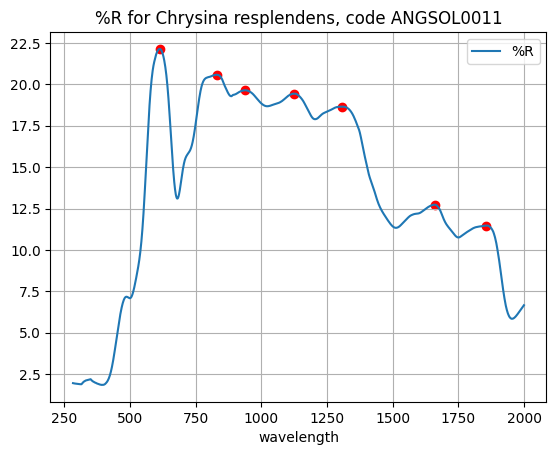

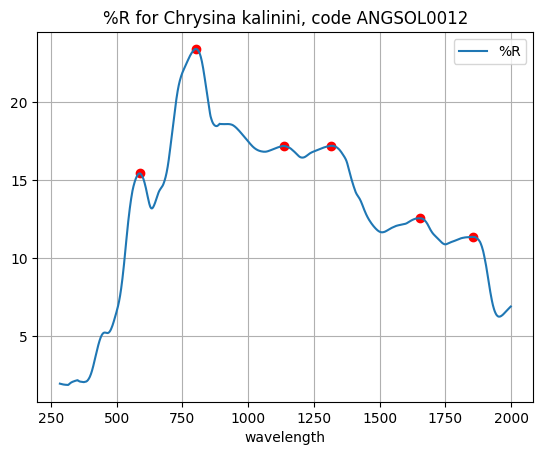

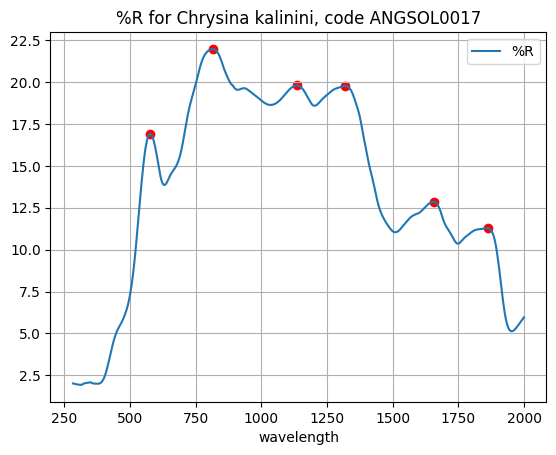

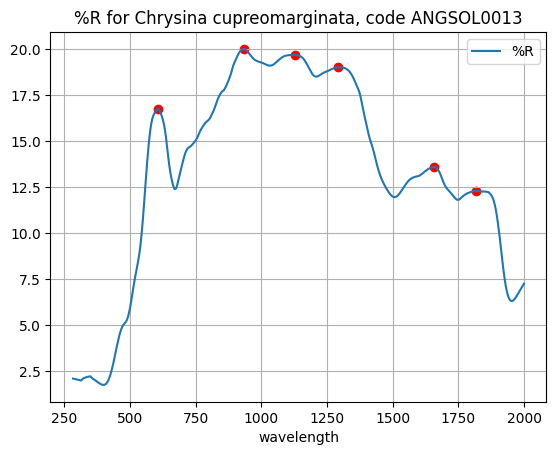

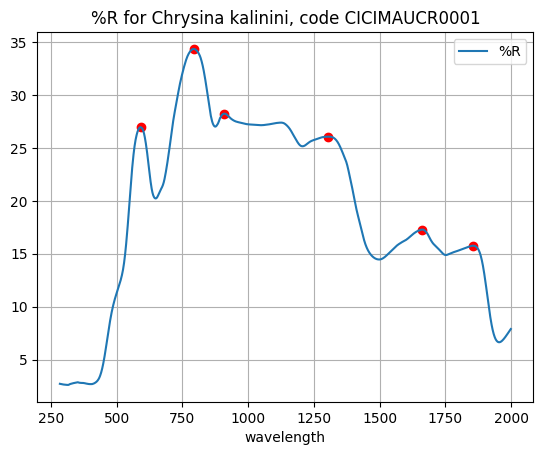

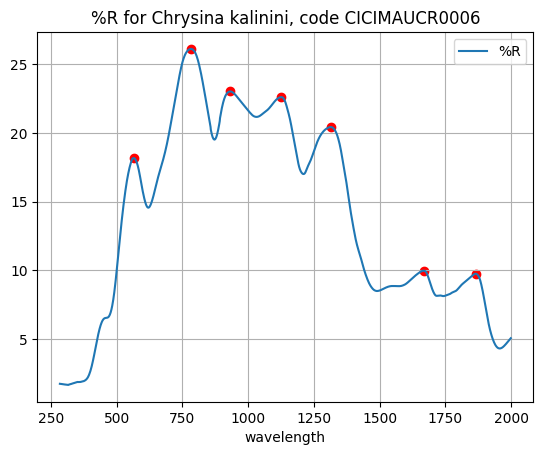

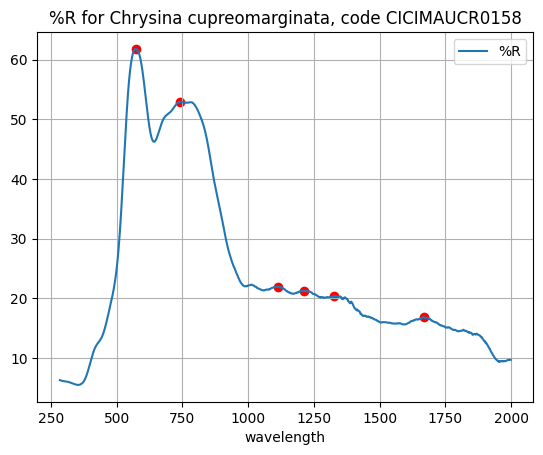

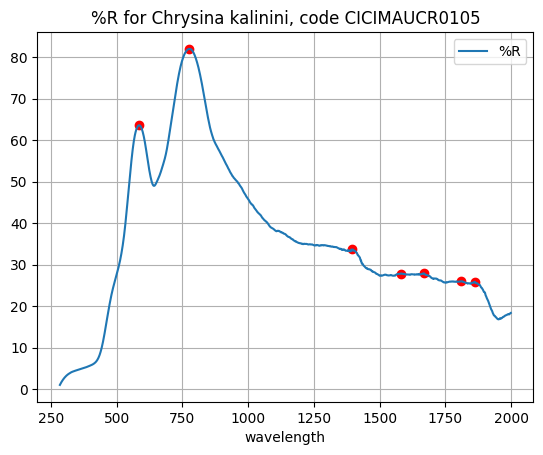

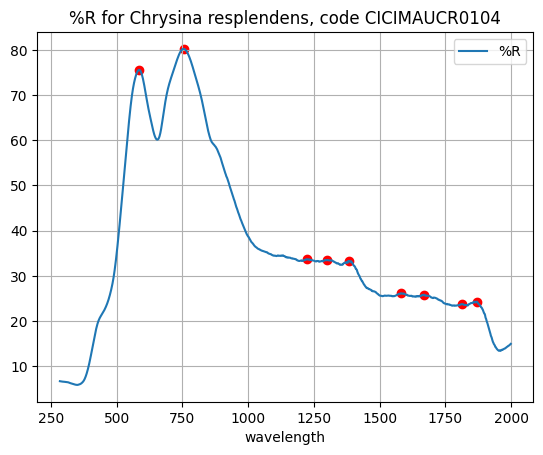

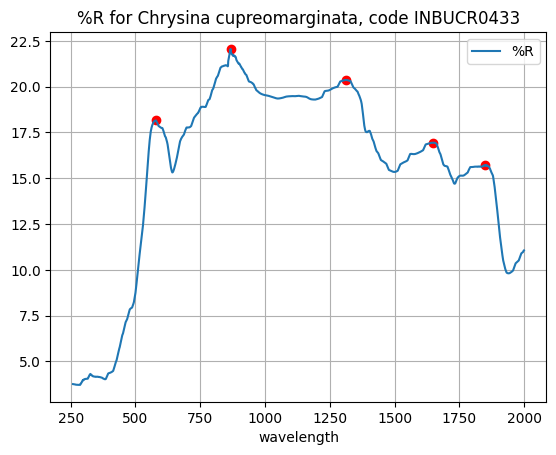

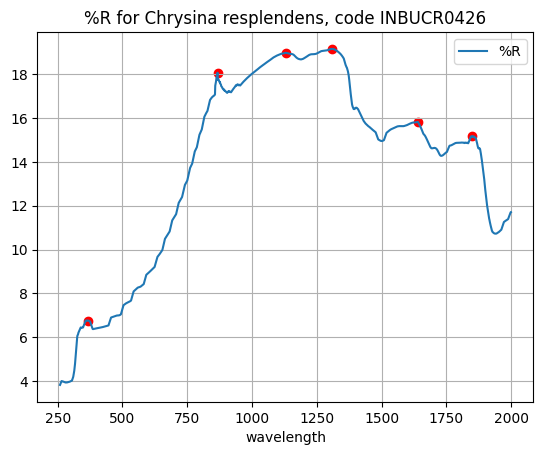

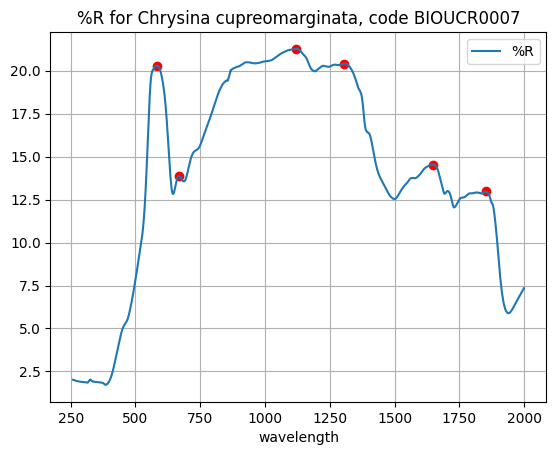

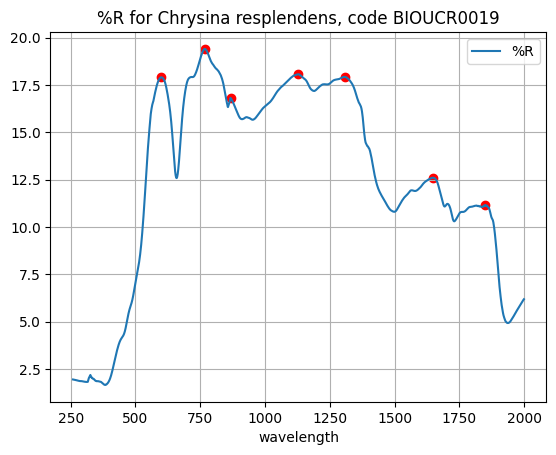

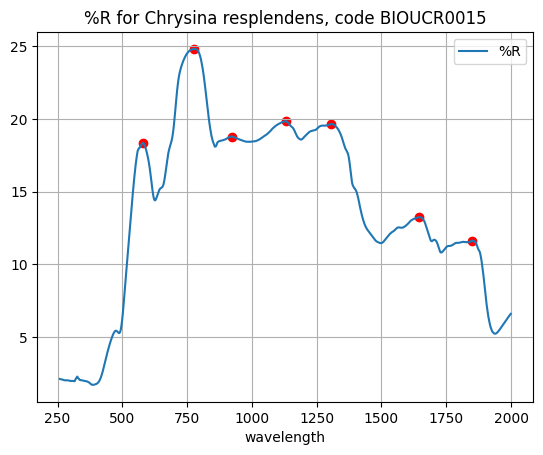

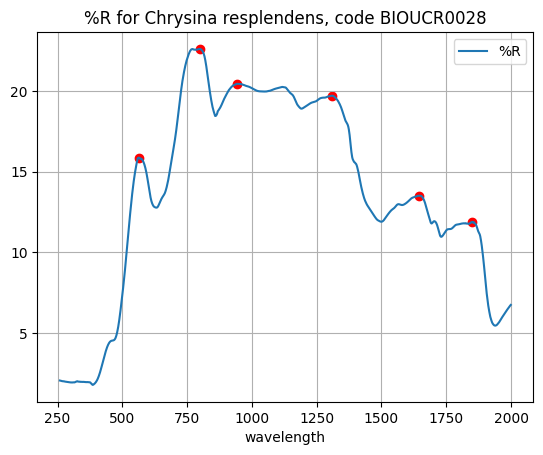

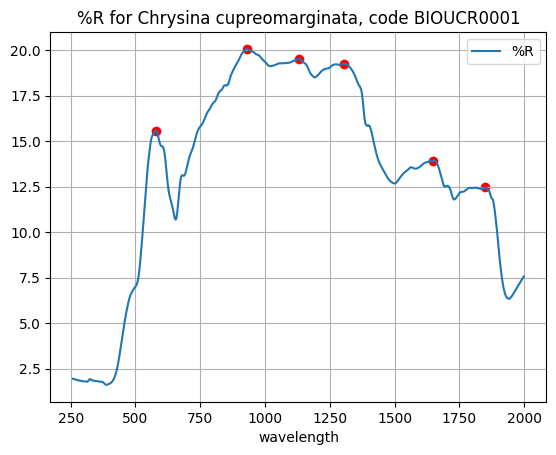

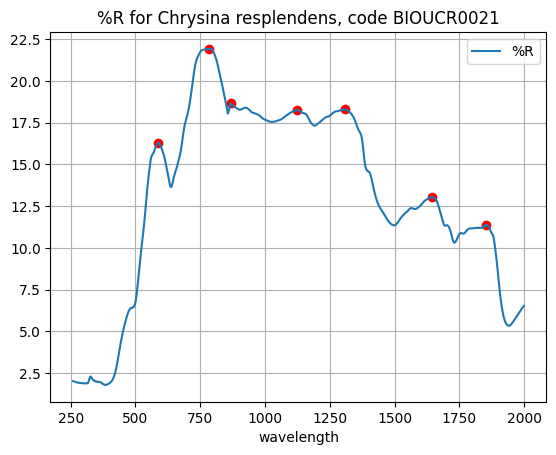

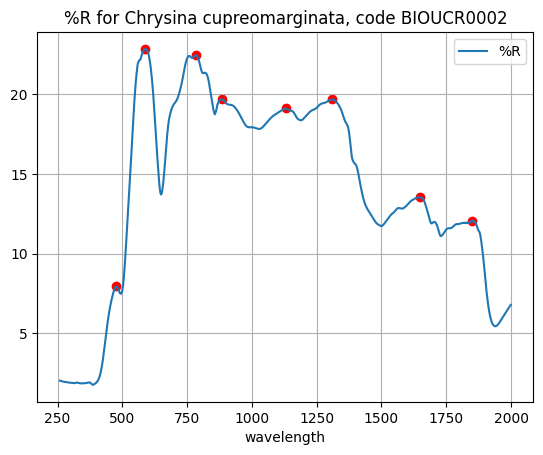

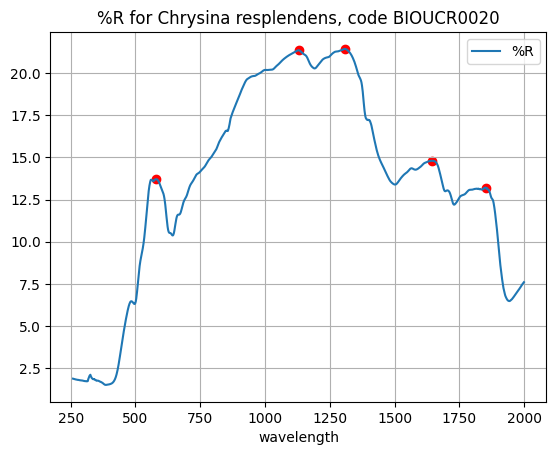

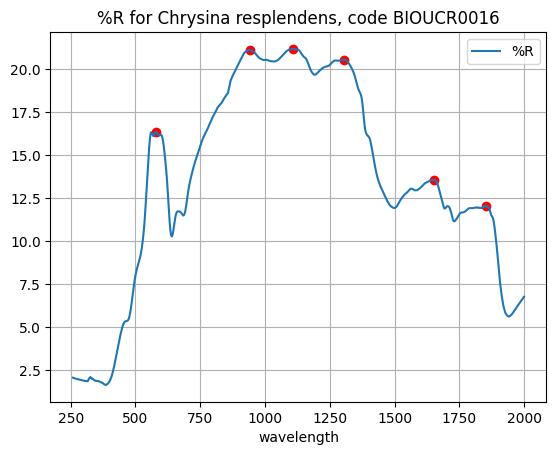

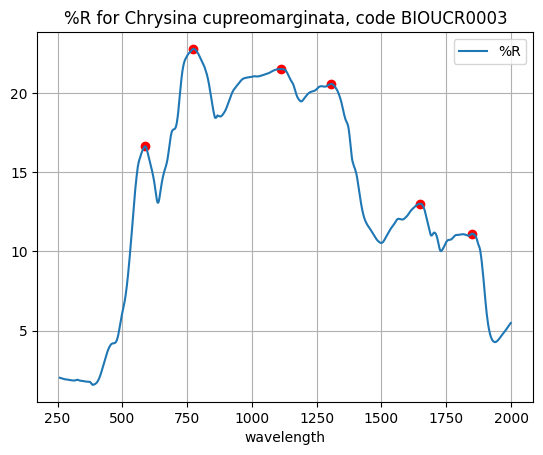

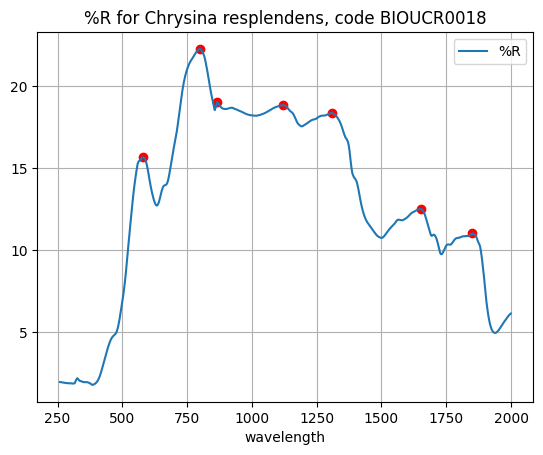

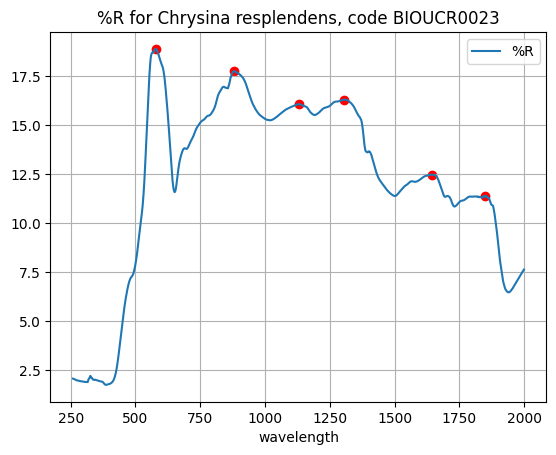

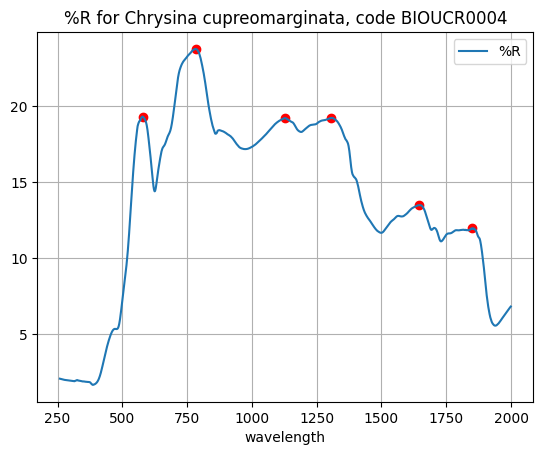

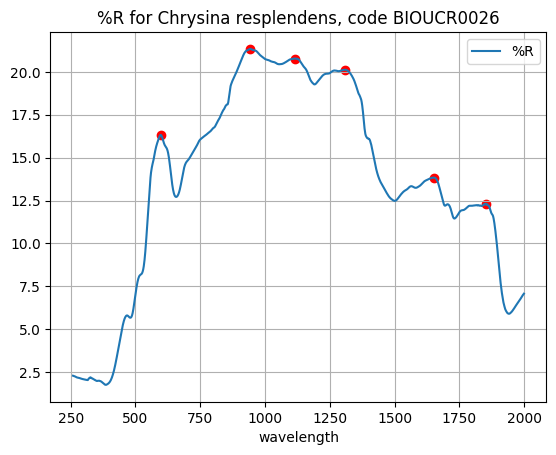

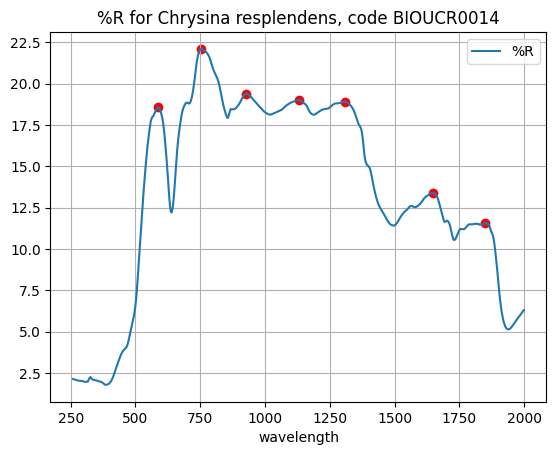

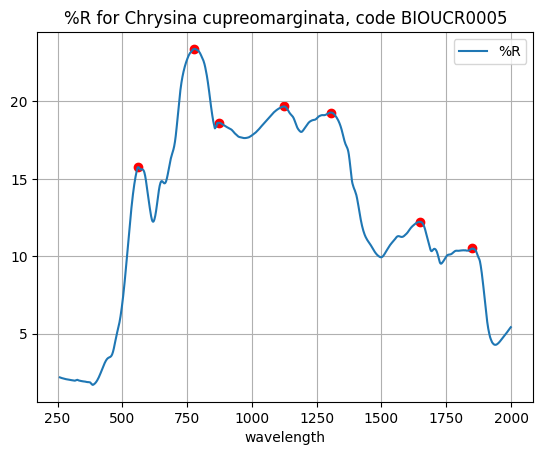

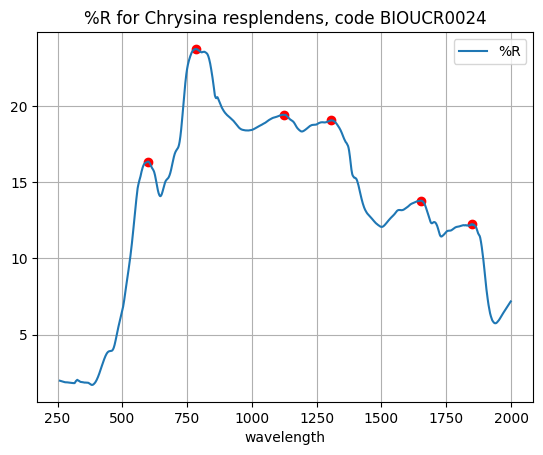

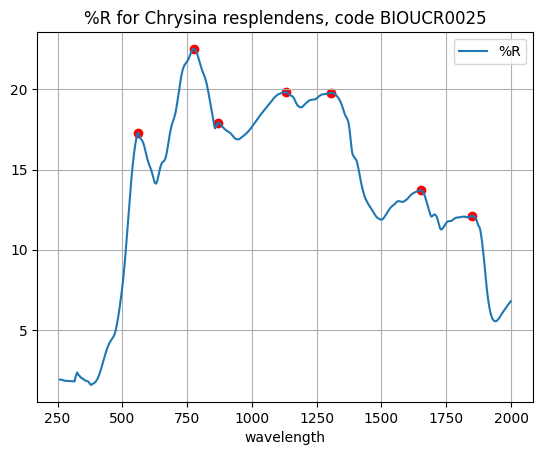

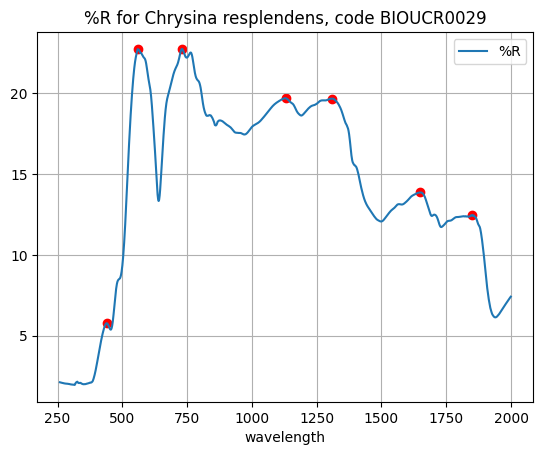

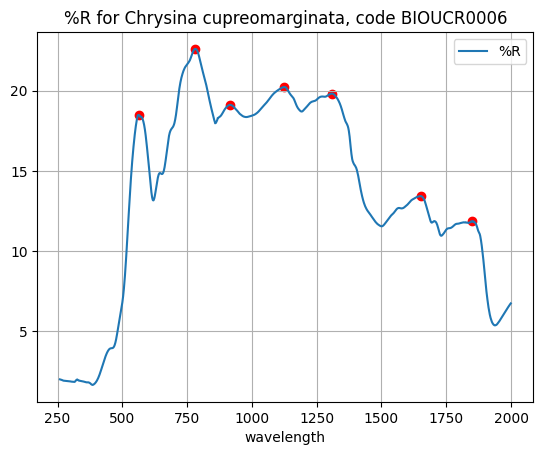

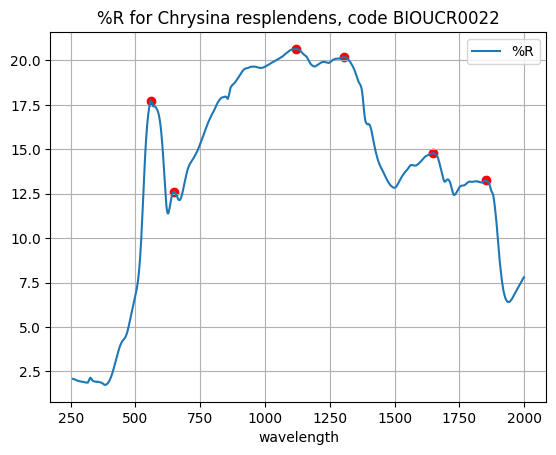

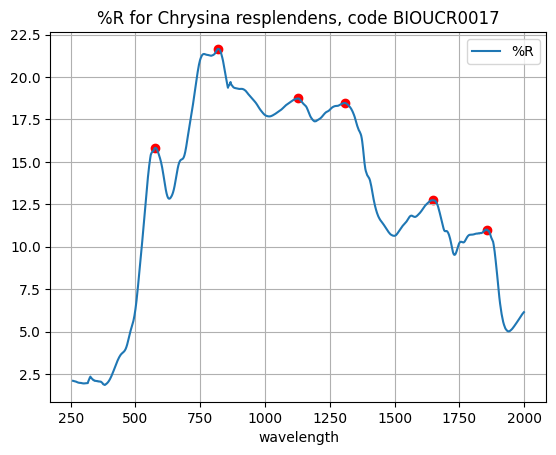

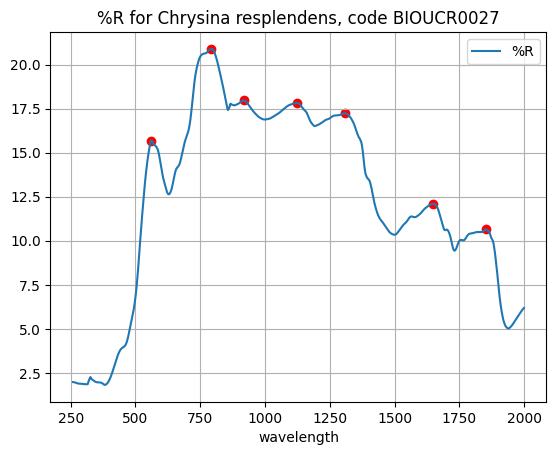

In [169]:
filtered_spectra, species_counter = get_filtered_spectra(collection_list)
specimen_section = get_specimen_section(filtered_spectra, species_counter)

### Gamma Testbench
This method is used to test each gamma factor implementation to determine how well it works to differentiate among different species.

In [149]:
def gamma_testbench(Gamma,filtered_spectra):

    #Calculate gammas

    gamma_list = []

    for spectrum in filtered_spectra:
        #print(spectrum.get_normalized_spectrum())
        try:
            gamma = Gamma(spectrum)
            gamma_list.append(gamma)
        except Exception as e:
            print(e)
    sorted(gamma_list)

    gamma_df = pd.DataFrame(columns=["species", "genus", "gamma", "code", "filename"])

    #add specimen information to the gammas
    for index, gamma in enumerate(gamma_list):
        gamma_df.loc[index,"species"] = gamma.spectrum.species
        gamma_df.loc[index,"genus"] = gamma.spectrum.genus
        gamma_df.loc[index,"gamma"] = gamma.gamma
        gamma_df.loc[index,"code"] = gamma.spectrum.code
        gamma_df.loc[index,"filename"] = gamma.spectrum.name

    #print(gamma_df)


    #Calculates gamma for resplendens, kalinini and cupreomarginata df
    #rkc_gamma_df = gamma_df[(gamma_df["species"] == "resplendens")|(gamma_df["species"] == "kalinini")|(gamma_df["species"] == "cupreomarginata")]

    #print(rkc_gamma_df)
    #finally, information is presented as a boxplot
    ax = gamma_df.boxplot(column=["gamma"], by=["species"], ax=None, fontsize=None, rot=90, grid=True, figsize=(4*3, 4*3), layout=None, return_type=None, backend=None, showfliers=False)
    fig = ax.figure
    plt.title(f" Algorithm: {Gamma.name() }. Collections: {collection_names}. \n Gamma values for C. resplendens, C. kalinini and C. cupreomarginata.")
    path= report_location +"\\" + f"{Gamma.name()} "+ database_descriptor + f"-{current_date}" +".jpeg"
    fig.savefig(path)
    return path

### TEST Gamma Algorithm

type <class 'str'> bp_path


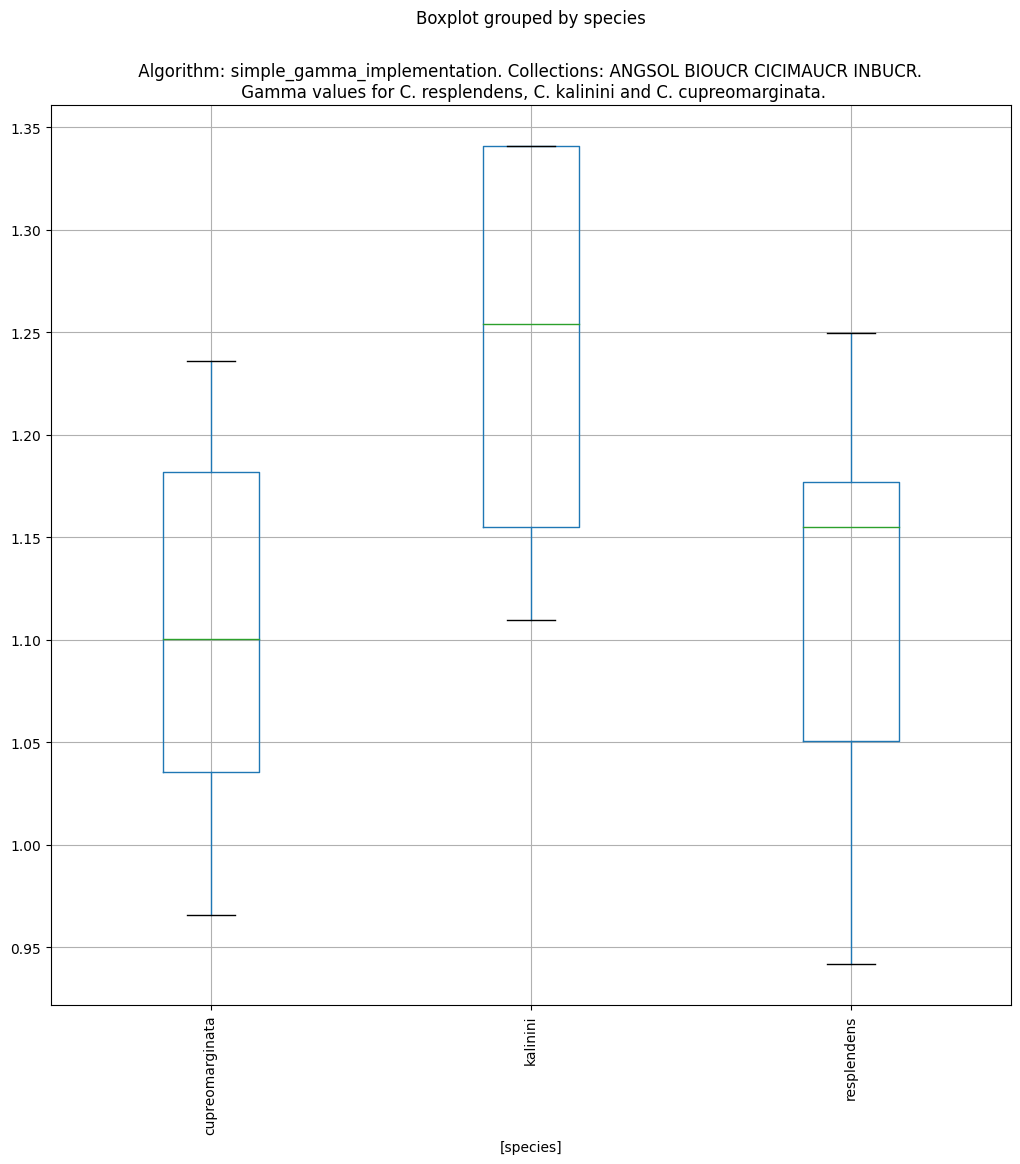

In [150]:

gamma_test = Gamma
bp_path =gamma_testbench(gamma_test, filtered_spectra)
print(f"type {type(bp_path)} bp_path")
simple_gamma_section = gamma_analysis( gamma_test, bp_path  , "sample_text", "sample_text")



### Peaks average and standard deviation per species:
It calculates the average and standard deviation of each peak

In [154]:
test_spectra = filtered_spectra
def peak_average_std_per_species(spectra):
    peaklists = [PeakList(spectrum) for spectrum in spectra]
    #Create a dataframe with all peaks, y peaks are normalized respect to the height of the first peak
    specimen_peak_points = pd.DataFrame([])
    for index, peaklist in enumerate(peaklists):

        peaks = peaklist.get_peaks()

        peak_0_x = peaks[0].x_value
        peak_0_y = peaks[0].y_value

        spectrum = peaklist.spectrum
        code = spectrum.code
        genus = spectrum.genus
        species= spectrum.species
        specimen_peak_points.loc[index, "code"] = code
        specimen_peak_points.loc[index, "genus"] = genus
        specimen_peak_points.loc[index, "species"] = species
        for i, peak in enumerate(peaks):
            label_x = f"x{i}"
            label_y = f"y{i}"
            specimen_peak_points.loc[index, label_x] = peak.x_value
            specimen_peak_points.loc[index, label_y] = peak.y_value/peak_0_y

    #specimen_peak_points
    #print(specimen_peak_points)
    #print(f"{peak_avg_std_df.loc[index:]}")
    #group values by species
    averages_df = specimen_peak_points.groupby('species')[['x0', 'y0','x1', 'y1', 'x2', 'y2','x3', 'y3','x4', 'y4', 'x5', 'y5']].mean().reset_index()
    standard_deviations_df = specimen_peak_points.groupby('species')[['x0', 'y0','x1', 'y1', 'x2', 'y2','x3', 'y3','x4', 'y4', 'x5', 'y5']].std().reset_index()

    #save information
    path_location = report_location + "\\agregated_data\\"
    create_path_if_not_exists(path_location)
    specimen_peak_points.to_csv( path_location+'peaks_krc.txt', index=False, sep = "\t")
    averages_df.to_csv(path_location+'peak_averages_krc.txt', index=False, sep = "\t")
    standard_deviations_df.to_csv(path_location+'peak_std_krc.txt', index=False, sep = "\t")

    #print(averages_df)
    #print(standard_deviations_df)

    return specimen_peak_points, averages_df, standard_deviations_df
specimen_peak_points, averages_df, standard_deviations_df = peak_average_std_per_species(filtered_spectra)

Directory '/content/drive/My Drive/CICIMA/escarabajos_files/L1050_data/report/gamma calculations\agregated_data\' created successfully.


In [157]:
#Now, for each spectrum we are going to calculate a gamma factor which is the sum of 1/(x-x0 + 1)^2 which are the values respect to the averages
#class Gamma_Peak_Inverse_Distance_Wavelength(Gamma, averages_df):


def similarity_index(spectrum, averages_df, standard_deviations_df , species):
    def distance(x, x0, sigma_0):
        index =  (((x - x0)**4)**(1/4))
        #print(f" x {x} - x0 {x0} = {(x - x0)} and index = {index}")
        return index
        #def get_gamma_factor(self, spectrum):
    #get first n peaks of the gamma
    n = 5
    peaklist = PeakList(spectrum)
    peaks = peaklist.get_peaks()[0:n]


    #loads species average values:


    averages_df = averages_df[averages_df["species"] == species]
    average_x_df = averages_df[["x0","x1","x2","x4","x5"]].values[0]

    standard_deviations_df = standard_deviations_df[standard_deviations_df["species"] == species]
    standard_deviation_x_df = standard_deviations_df[["x0","x1","x2","x4","x5"]].values[0]

    #print(f"averages_df: {averages_df}")
    #for each peak, calculate the distances to the averages x values
    gamma = 0.0

    for peak_i,xi_0, sigmai_0 in zip(peaks, average_x_df, standard_deviation_x_df):
        xi = peak_i.x_value
        gamma += distance(xi, xi_0, sigmai_0)

    #normalize for the number of points
    gamma = gamma/n
    #print(f"gamma: {gamma}")
    return gamma

specimen_peak_points, averages_df, standard_deviations_df = peak_average_std_per_species(filtered_spectra)
#agregated_data_avg_path = avg_path= r"E:\CICIMA\Estudio Optico Escarabajos\data_analysis\report_test\agregated_data_final\peak_averages_krc.txt"
#agregated_data_std_dev_path =std_dev_path = r"E:\CICIMA\Estudio Optico Escarabajos\data_analysis\report_test\agregated_data_final\peak_averages_krc.txt"
with open(agregated_data_avg_path, encoding= "latin1") as f:
    averages_df_0 = pd.read_csv(f, delimiter="\t", header=0)


with open(agregated_data_std_dev_path, encoding= "latin1") as f:
    standard_deviations_df_0 = pd.read_csv(f, delimiter="\t", header=0)




def test_tool(correct_species, kali_si, cupr_si, resp_si):
    my_list =  [kali_si, cupr_si, resp_si]
    min_index = my_list.index(min(my_list))

    if (min_index == 0):
        return correct_species == "kalinini"
    if (min_index == 1):
        return correct_species == "cupreomarginata"
    if (min_index == 2):
        return correct_species == "resplendens"

similarity_index_text_df = pd.DataFrame([])
for k, spectrum in enumerate(filtered_spectra):
    kali_si = similarity_index(spectrum, averages_df_0, standard_deviations_df_0 , "kalinini")
    cupr_si = similarity_index(spectrum, averages_df_0, standard_deviations_df_0 , "cupreomarginata")
    resp_si = similarity_index(spectrum, averages_df_0, standard_deviations_df_0 , "resplendens")
    similarity_index_text_df.loc[k,"code"] = spectrum.code
    similarity_index_text_df.loc[k,"species"] =spectrum.species
    similarity_index_text_df.loc[k,"kali_si"] = kali_si
    similarity_index_text_df.loc[k,"cupr_si"] = cupr_si
    similarity_index_text_df.loc[k,"resp_si"] = resp_si
    similarity_index_text_df.loc[k,"test_result"] = test_tool(spectrum.species, kali_si, cupr_si, resp_si)
    #print(f"similarity indices for {spectrum.species}: kali {kali_si}, cupreo {cupr_si}, resp_si {resp_si}")
    #print(f"Test tool: {test_tool(spectrum.species, kali_si, cupr_si, resp_si)}")
print(similarity_index_text_df)
count_by_test_result = similarity_index_text_df.groupby('test_result').size().reset_index(name='count')
print(f"count {count_by_test_result}")



Directory '/content/drive/My Drive/CICIMA/escarabajos_files/L1050_data/report/gamma calculations\agregated_data\' already exists.
             code          species  kali_si  cupr_si  resp_si test_result
0      ANGSOL0011      resplendens   239.68    202.9    145.0        True
1      ANGSOL0012         kalinini    96.04     63.5     28.4       False
2      ANGSOL0017         kalinini    96.60     61.1     32.4       False
3      ANGSOL0013  cupreomarginata   129.44     81.5     57.8       False
4   CICIMAUCR0001         kalinini   127.52    105.3     53.2       False
5   CICIMAUCR0006         kalinini   231.68    212.7    144.0       False
6   CICIMAUCR0158  cupreomarginata   186.64    163.1    107.4       False
7   CICIMAUCR0105         kalinini    93.68    100.7    125.8        True
8   CICIMAUCR0104      resplendens   175.68    146.9     94.6        True
9      INBUCR0433  cupreomarginata    76.68     98.9    171.8       False
10     INBUCR0426      resplendens   153.80    109.1    

In [158]:
# Create sections with headings, paragraphs, and figures
def similarity_index_section(df ):

    #Define sections and results
    sections = {}
    results =[]
    information = []

    # Section 1: Introduction
    description = []
    title = [Paragraph(f"Similarity Index:", getSampleStyleSheet()["Heading2"]), Spacer(1, 12),

                    Paragraph("For each spectrum a similarity index is calculated which is the sum of the squared differences between the wavelength peak values of the unknown sample and the average wavelength peak values for each species.", getSampleStyleSheet()["Normal"]),
                    Spacer(1, 12)]
    description += title



    #Add table with species info

    sub_title = [Paragraph(f"Test results:", getSampleStyleSheet()["Heading3"]), Spacer(1, 6),Paragraph("The reported(correct) species is compared with the species with the lowest similarity index (si), the final column (test_result) shows if the species coincide:", getSampleStyleSheet()["Normal"]),
                    Spacer(1, 12)]

    information += sub_title

    #create table with test result info
    names = df.columns.tolist()
    #names = ["a","a","a","a","a","a",]
    values_table =  df.values.tolist()

    info = [names, *values_table]
    print(info)
    #info =  df.values.tolist()
    #create table
    table2 = Table(info)
    style = TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.white),
                        ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),
                        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                        ('BACKGROUND', (0, 1), (-1, -1), colors.white),
                        ('GRID', (0, 0), (-1, -1), 1, colors.black)])

    table2.setStyle(style)
    information.append(table2)
    information.append(PageBreak())


    return description  + information

In [159]:
similarity_index_section = similarity_index_section(similarity_index_text_df )

[['code', 'species', 'kali_si', 'cupr_si', 'resp_si', 'test_result'], ['ANGSOL0011', 'resplendens', 239.67999999999998, 202.9, 145.0, True], ['ANGSOL0012', 'kalinini', 96.04, 63.5, 28.4, False], ['ANGSOL0017', 'kalinini', 96.6, 61.1, 32.4, False], ['ANGSOL0013', 'cupreomarginata', 129.44, 81.5, 57.8, False], ['CICIMAUCR0001', 'kalinini', 127.51999999999998, 105.3, 53.2, False], ['CICIMAUCR0006', 'kalinini', 231.67999999999998, 212.7, 144.0, False], ['CICIMAUCR0158', 'cupreomarginata', 186.64000000000001, 163.1, 107.4, False], ['CICIMAUCR0105', 'kalinini', 93.68000000000002, 100.7, 125.8, True], ['CICIMAUCR0104', 'resplendens', 175.68, 146.9, 94.6, True], ['INBUCR0433', 'cupreomarginata', 76.68000000000002, 98.9, 171.8, False], ['INBUCR0426', 'resplendens', 153.8, 109.1, 83.2, True], ['BIOUCR0007', 'cupreomarginata', 118.08000000000001, 91.9, 50.0, False], ['BIOUCR0019', 'resplendens', 249.32, 227.1, 154.6, True], ['BIOUCR0015', 'resplendens', 232.67999999999998, 213.7, 145.0, True], ['

### Algorithm 3: Trapezoidal integration. Naive
This algorithm compares the area under the curve under the visible and IR region and compares them. Makes a cut at 800 nm

In [160]:
class GammaAreaUnderCurveNaive(Gamma):
    #this is a subclass of Gamma
    #get_gamma_factor must be redefined
    visible_start_wavelength = 450
    visible_end_wavelength = ir_start_wavelength = 800
    ir_end_wavelength = 1500

    def name():
        return "Gamma_area_under_curve_naive"

    def description():
        return f"This method calculates the ratio between the area under the curve for the spectrum between {GammaAreaUnderCurveNaive.visible_start_wavelength} and {GammaAreaUnderCurveNaive.visible_end_wavelength} nm (visible range) and between {GammaAreaUnderCurveNaive.ir_start_wavelength} nm and {GammaAreaUnderCurveNaive.ir_end_wavelength} nm (Infrarred range)."


    def get_gamma_factor(self, spectrum):

        def get_area_under_curve(spectrum, start_wavelength, finish_wavelength):
            # Assuming your DataFrame is named df and has columns 'wavelength' and 'height'
            # Let's say you have start_wavelength and finish_wavelength variables for the range you want to integrate over
            # Subset the DataFrame to the range of interest
            subset_df = df[(df['wavelength'] >= start_wavelength) & (df['wavelength'] <= finish_wavelength)]

            # Extract the wavelengths and heights as arrays
            wavelengths = subset_df['wavelength'].values
            heights = subset_df[spectrum.measuring_mode].values

            # Calculate the area under the curve using the trapezoidal rule
            area_under_curve = np.trapz(heights, wavelengths)

            print("Area under the curve:", area_under_curve)
            return area_under_curve

        import numpy as np
        df = spectrum.get_normalized_spectrum()
        area_uv_visible = get_area_under_curve(spectrum, GammaAreaUnderCurveNaive.visible_start_wavelength, GammaAreaUnderCurveNaive.visible_end_wavelength)
        area_ir = get_area_under_curve(spectrum, GammaAreaUnderCurveNaive.ir_start_wavelength, GammaAreaUnderCurveNaive.ir_end_wavelength)
        gamma = area_uv_visible/area_ir
        return gamma


### Test Gamma Under Curve: Naive

Area under the curve: 236.1784844487955
Area under the curve: 569.9981401838616
Area under the curve: 215.66619517900932
Area under the curve: 508.06796800679
Area under the curve: 231.65248357628138
Area under the curve: 589.0289762020038
Area under the curve: 216.42372220351183
Area under the curve: 631.666335680341
Area under the curve: 226.19847608934646
Area under the curve: 518.8709735045572
Area under the curve: 231.23418612393627
Area under the curve: 511.8805434861962
Area under the curve: 262.71918075822157
Area under the curve: 276.2093847919922
Area under the curve: 230.80296073586317
Area under the curve: 358.69948602802924
Area under the curve: 272.1085478830979
Area under the curve: 341.97176227351224
Area under the curve: 245.58767092740095
Area under the curve: 614.9946945541914
Area under the curve: 182.06171989016053
Area under the curve: 650.8106530182058
Area under the curve: 231.3243867588663
Area under the curve: 633.2769531404858
Area under the curve: 260.145474

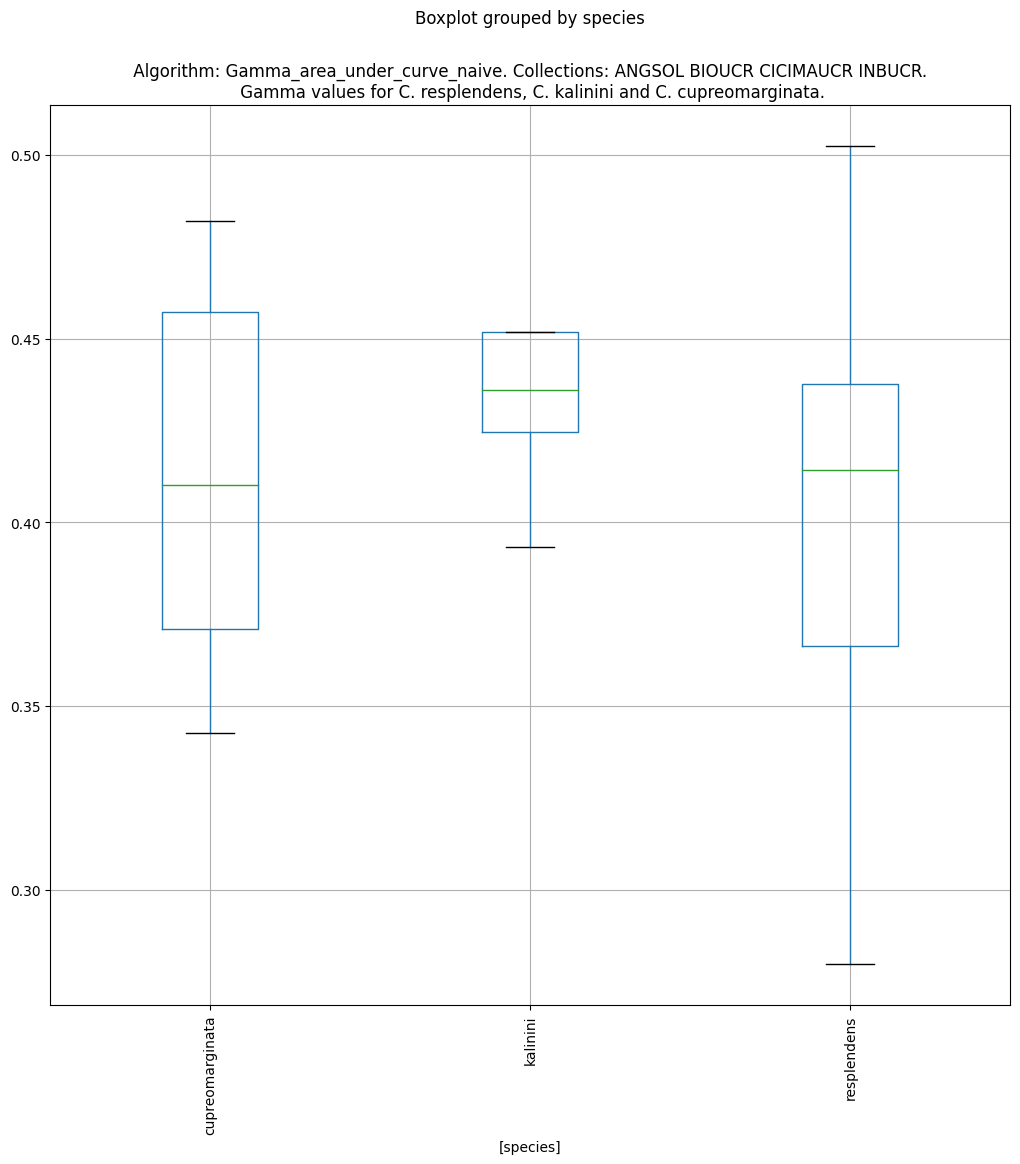

In [161]:
gamma_test = GammaAreaUnderCurveNaive
bp_path =gamma_testbench(gamma_test, filtered_spectra)
print(f"type {type(bp_path)} bp_path")
gamma_area_under_curve_naive_section = gamma_analysis( gamma_test, bp_path  , "sample_text", "sample_text")


### Algorithm 4: Trapezoidal integration. Minimum detection
This algorithm compares the area under the curve under the visible and IR region and compares them. Makes a cut at the first minimum

In [162]:
def get_minima(spectrum):
    #Get minimum
    #def get_minimum(
    import scipy

    #get wavelength and height of measurements
    x = spectrum.data["wavelength"].values
    y = spectrum.data[spectrum.metadata["measuring_mode"]].values
    #reflect plot across x axis and displace it upwards
    y_max = y.max()
    y_inverted = -y + y_max
    min_distance = 50 #min distance between two minima

    #get minima
    #peaks_funct = scipy.signal.find_peaks(y_inverted, height= min_height, distance= min_distance, prominence=0.15)
    peaks_funct = scipy.signal.find_peaks(y_inverted, distance= min_distance, prominence=prominence_threshold_min)
    peaks_index = peaks_funct[0]
    x_values = x[peaks_index]
    y_values = y[peaks_index]

    print("plot minima")
    plt.plot(x, y)
    plt.grid(True)
    plt.scatter(x_values, y_values)
    plt.show()
    return peaks_index, x_values, y_values

In [163]:
def get_maxima(spectrum):
    import scipy
    #get wavelength and height of measurements
    x = spectrum.data["wavelength"].values
    y = spectrum.data[spectrum.metadata["measuring_mode"]].values

    #define minimum height and min distance between minima
    min_height = y.max()/min_height_threshold_denominator
    min_distance = 50 #nm
    max_distance = 100.00
    width_t = 50.00

    #get maxima
    peaks_funct = scipy.signal.find_peaks(y, height= min_height, distance= min_distance, prominence= prominence_threshold_max)
    peaks_index = peaks_funct[0] #indices
    x_values = x[peaks_index]   #x values
    y_values = y[peaks_index]    #y values

    #plot
    print("plot maxima")
    plt.plot(x, y)
    plt.grid(True)
    plt.scatter(x_values, y_values)
    plt.show()
    return peaks_index, x_values, y_values


In [164]:
def get_area_under_curve(spectrum, start_wavelength, finish_wavelength):
            # Assuming your DataFrame is named df and has columns 'wavelength' and 'height'
            # Let's say you have start_wavelength and finish_wavelength variables for the range you want to integrate over
            # Subset the DataFrame to the range of interest
            subset_df = df[(df['wavelength'] >= start_wavelength) & (df['wavelength'] <= finish_wavelength)]

            # Extract the wavelengths and heights as arrays
            wavelengths = subset_df['wavelength'].values
            heights = subset_df[spectrum.measuring_mode].values

            # Calculate the area under the curve using the trapezoidal rule
            area_under_curve = np.trapz(heights, wavelengths)

            print("Area under the curve:", area_under_curve)
            print("DEBUG method, delete in production")
            return area_under_curve

In [165]:
class  GammaAreaFirstMinCut(Gamma):
    #this is a subclass of Gamma
    #get_gamma_factor must be redefined
    visible_range_start_wavelength = 450
    def name():
        return "gamma_area_under_curve_cut_first_minimum"
    def description():
        return f"This algorithm calculates the area for the visible region (starting at {GammaAreaFirstMinCut.visible_range_start_wavelength} and ending in the first minima between the maximum in the visible range and the maximum in the IR range. Then calculates the area of the IR range up to the second minumum. The ratio between these two areas is the gamma value."

    def get_gamma_factor(self, spectrum):

        def get_area_under_curve(spectrum, start_wavelength, finish_wavelength):
            # Assuming your DataFrame is named df and has columns 'wavelength' and 'height'
            # Let's say you have start_wavelength and finish_wavelength variables for the range you want to integrate over
            # Subset the DataFrame to the range of interest
            subset_df = df[(df['wavelength'] >= start_wavelength) & (df['wavelength'] <= finish_wavelength)]

            # Extract the wavelengths and heights as arrays
            wavelengths = subset_df['wavelength'].values
            heights = subset_df[spectrum.measuring_mode].values

            # Calculate the area under the curve using the trapezoidal rule
            area_under_curve = np.trapz(heights, wavelengths)

            # print("Area under the curve:", area_under_curve)
            return area_under_curve

        import numpy as np

        #test_spectrum = filtered_spectra[0]
        #get the highest data recorded
        max_value = spectrum.data[spectrum.measuring_mode].max()
        #get maxima and minima
        x = spectrum.data["wavelength"].values
        y = spectrum.data[spectrum.measuring_mode].values

        #get x and y positions of maxima and minima
        max_i, max_xs, max_ys = get_maxima(spectrum)
        min_i, min_xs, min_ys= get_minima(spectrum)
        #
        # print(f"type min_i {type(min_i)}, content {min_i}")
        # print(f"type max_i {type(max_i)}, content {max_i}")
        # print(f"type max_xs {type(max_xs)}, content {max_xs}")
        # print(f"type max_ys {type(max_ys)}, content {max_ys}")
        # print(f"type min_xs {type(min_xs)}, content {min_xs}")
        # print(f"type min_ys {type(min_ys)}, content {min_ys}")

        #get x locations of first and second maxima and the minimum in between
        first_max_x = max_xs[0]
        try:
            second_max_x = max_xs[1]
        except Exception as e:
            second_max_x = x.max()
            print(e)
        try:
            second_max_y = max_ys[1]
        except Exception as e:
            second_max_y = 0
            print(e)

        min_in_between_i = 0
        min_in_between_x =0
        min_in_between_y =0
        #get the location of the minimum in between
        for index in min_i:
            #print("index")
            if first_max_x <= x[index] <= second_max_x:
                min_in_between_i = index
                min_in_between_x = x[index]
                min_in_between_y = y[index]
                break

        # print(f"min in bet: {min_in_between_i} {min_in_between_x} {min_in_between_y} ")
        #second minimum
        #get the location of the second minimum
        min_after_second_max_i = 0
        min_after_second_max_x = 0
        min_after_second_max_y = 0
        for index in min_i:
            # print(f" second_max_x  <= x[index] { second_max_x  <= x[index]}")
            if second_max_x  <= x[index]:
                min_after_second_max_i = index
                min_after_second_max_x = x[index]
                min_after_second_max_y = y[index]
                break


        # print(f"min after: {min_after_second_max_i} {min_after_second_max_x} {min_after_second_max_y} ")

        x_values = [first_max_x, min_in_between_x, second_max_x, min_after_second_max_x]
        y_values = [max_ys[0]/max_value, min_in_between_y/max_value, second_max_y/max_value, min_after_second_max_y/max_value]
        #get the normalized spectrum
        df = spectrum.get_normalized_spectrum()
        #plot
        x = df["wavelength"].values
        y =df[spectrum.measuring_mode].values

        #modify y to have last value equal to first one
        y_mod = y
        y_mod[-1] = y_mod[0]
        plt.plot(x,y_mod)
        plt.fill(x, y_mod, "y")
        #split x, y LEFT
        print(f"fmi: {min_in_between_i}")
        x_left = x[:min_in_between_i]
        y_left = y[:min_in_between_i]
        #set last one to zero for picture to be displaye properly
        y_left[-1] = y_left[0]
        plt.plot(x_left,y_left)
        plt.fill(x_left, y_left, "b")

        #split x, y RIGHT
        #print(f"min_after_second_max_i: {min_after_second_max_i}")
        x_right = x[min_in_between_i:min_after_second_max_i]
        y_right = y[min_in_between_i:min_after_second_max_i]
        #set last one to zero for picture to be displaye properly
        y_right[0] = y_right[-1] = y_left[0]
        plt.plot(x_right,y_right)
        plt.fill(x_right, y_right, "g")
        #show figure
        plt.show()

        area_uv_visible = get_area_under_curve(spectrum, GammaAreaFirstMinCut.visible_range_start_wavelength, min_in_between_x)
        area_ir = get_area_under_curve(spectrum, min_in_between_x, min_after_second_max_x)
        gamma = area_uv_visible/area_ir
        print(f"gamma: {gamma}")
        return gamma




plot maxima


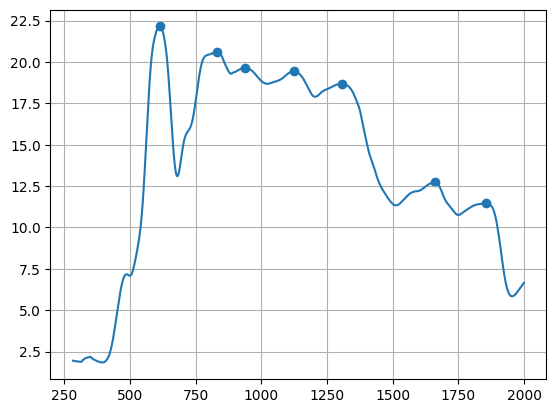

plot minima


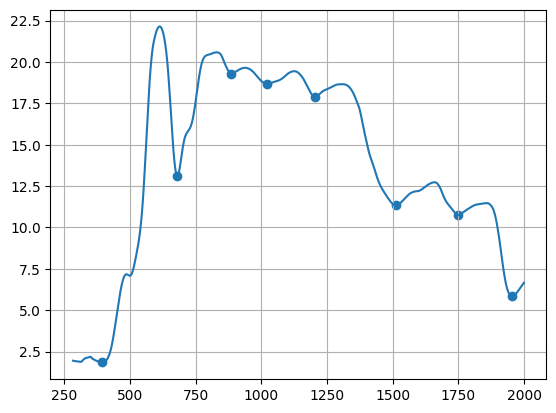

fmi: 397


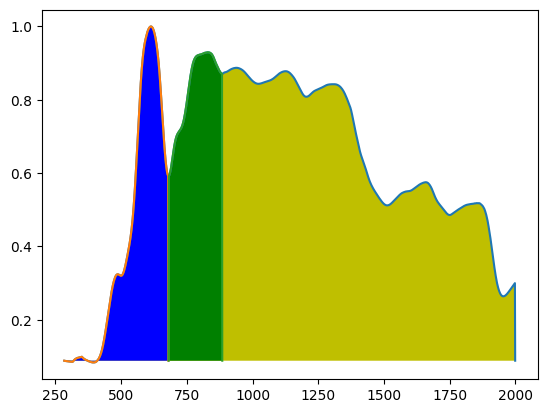

gamma: 0.8444948744154045
plot maxima


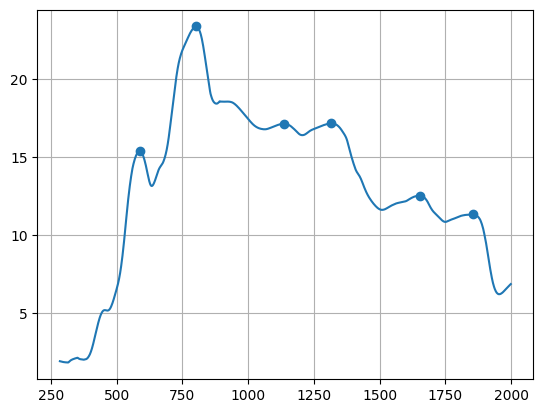

plot minima


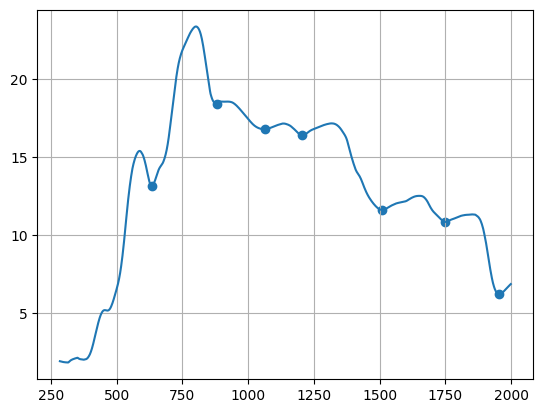

fmi: 349


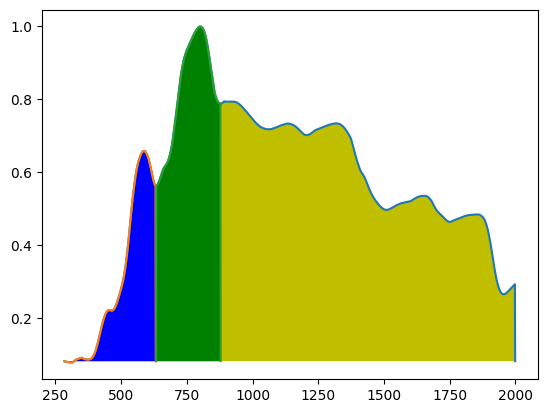

gamma: 0.4090629229051765
plot maxima


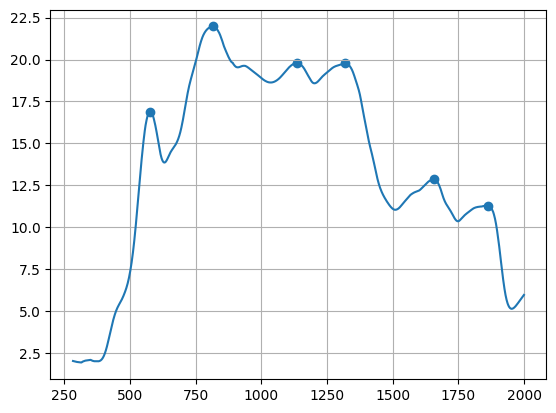

plot minima


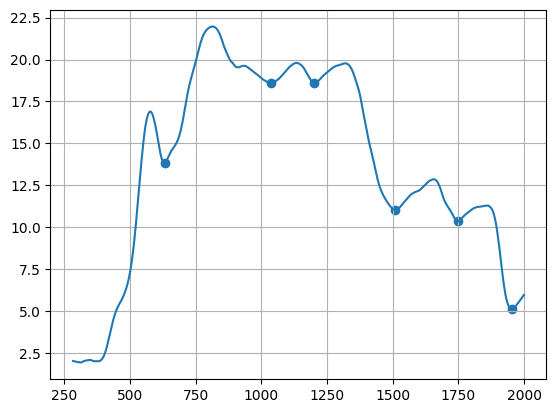

fmi: 348


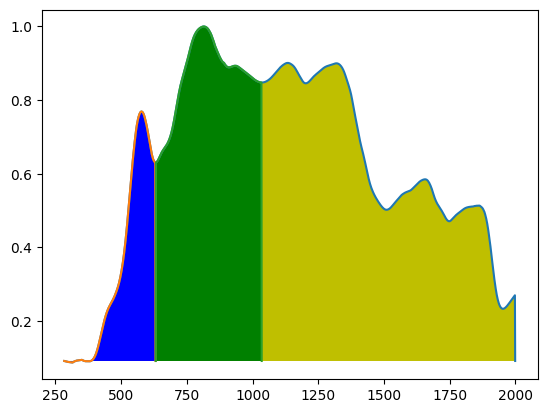

gamma: 0.2738645387108693
plot maxima


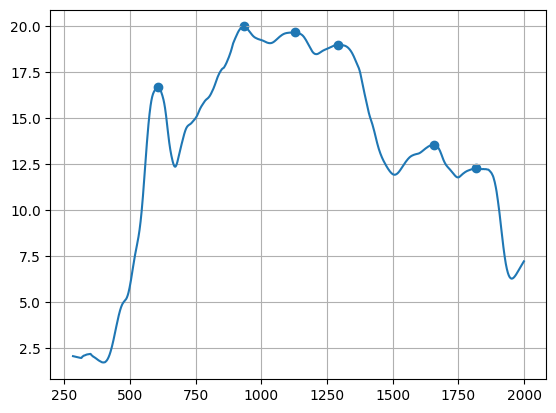

plot minima


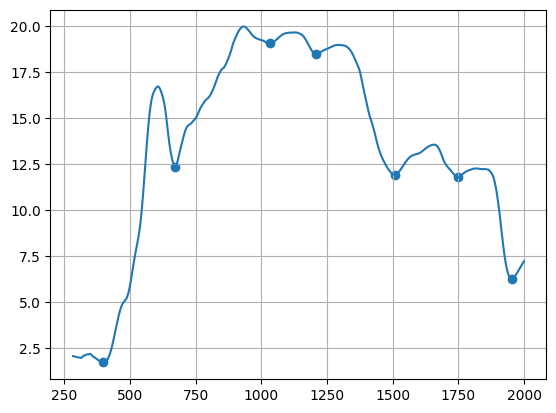

fmi: 388


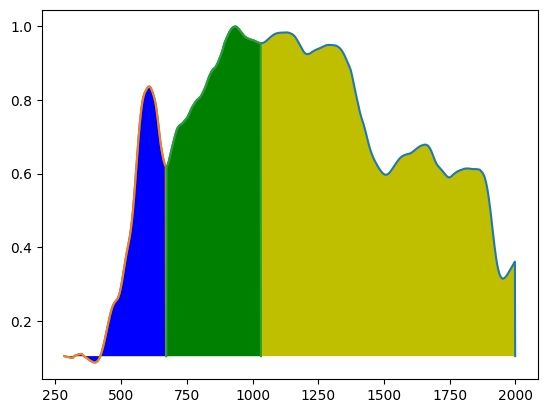

gamma: 0.39249293133770086
plot maxima


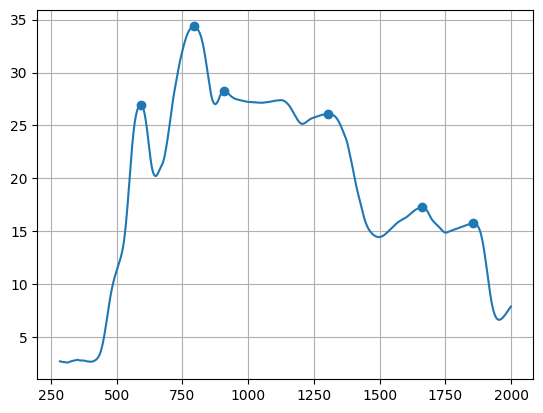

plot minima


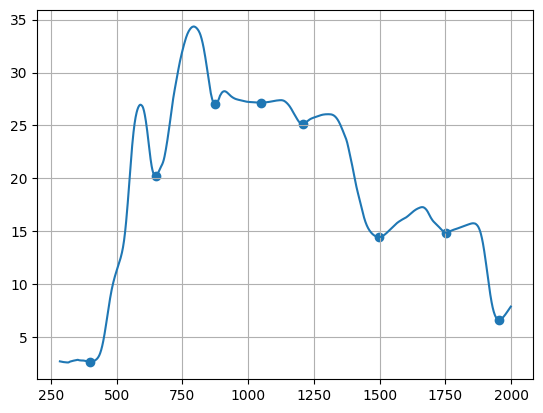

fmi: 364


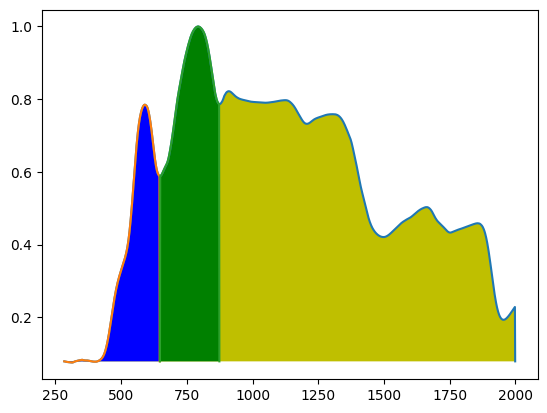

gamma: 0.5322305555758922
plot maxima


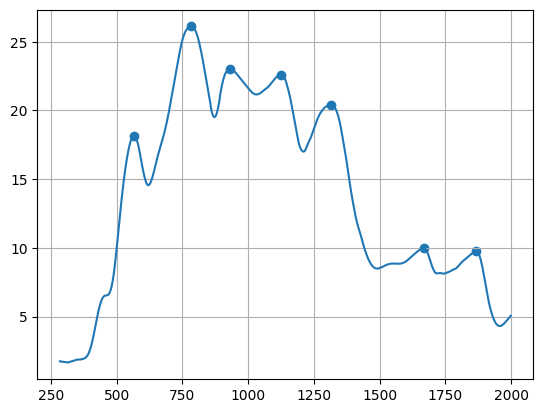

plot minima


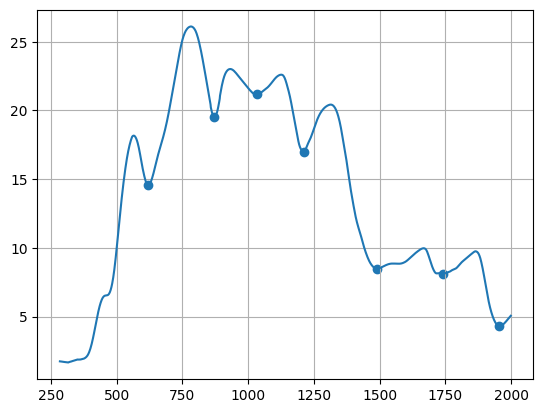

fmi: 336


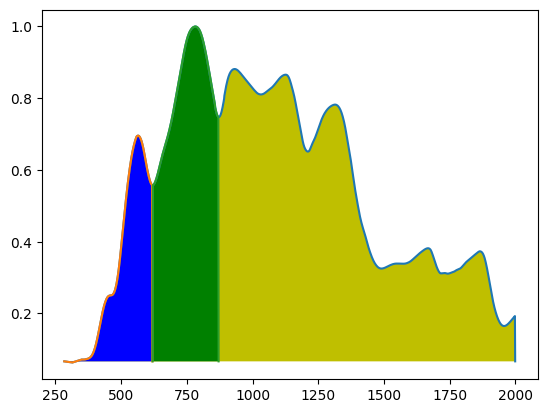

gamma: 0.41438564507741515
plot maxima


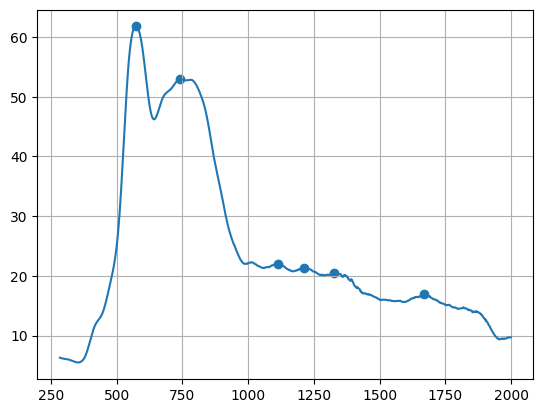

plot minima


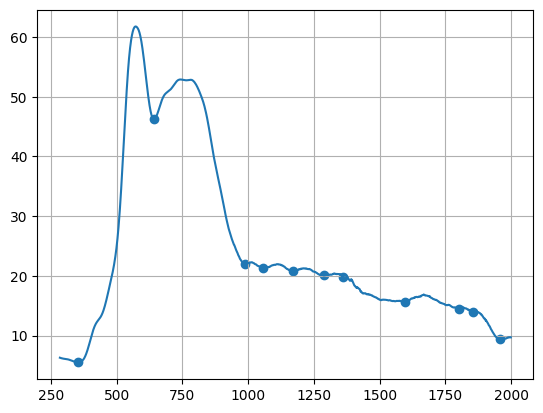

fmi: 358


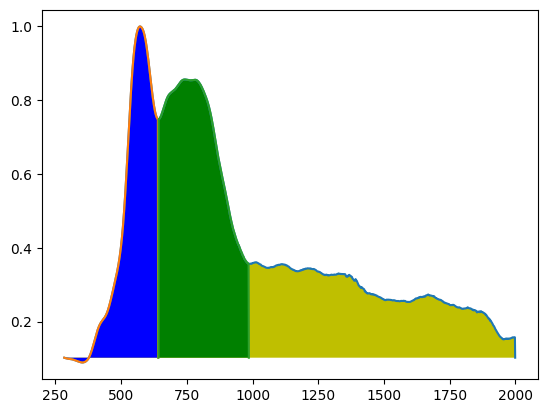

gamma: 0.5482720123206339
plot maxima


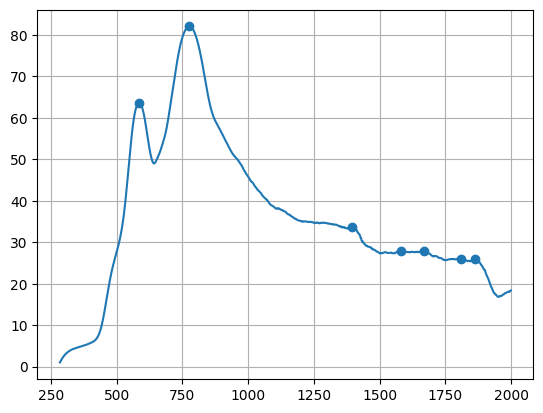

plot minima


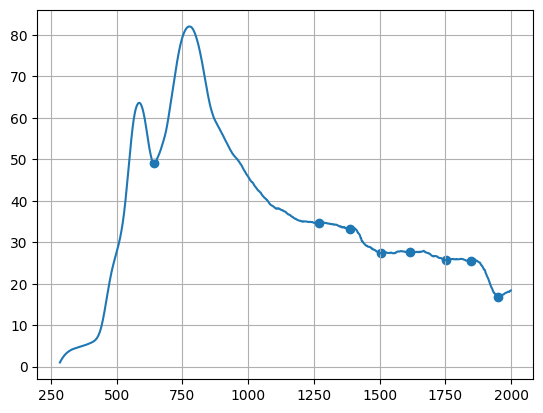

fmi: 358


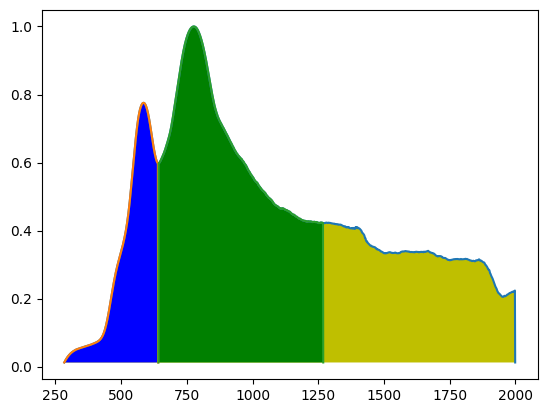

gamma: 0.24860009192671398
plot maxima


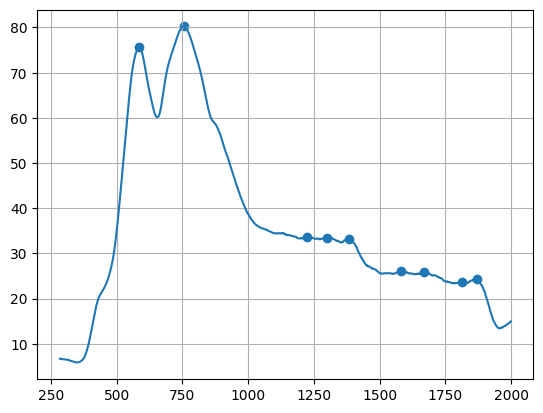

plot minima


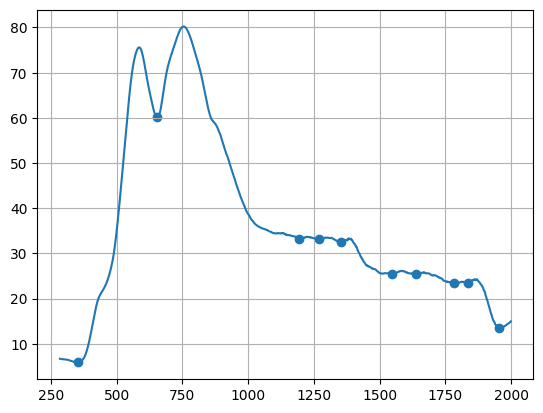

fmi: 371


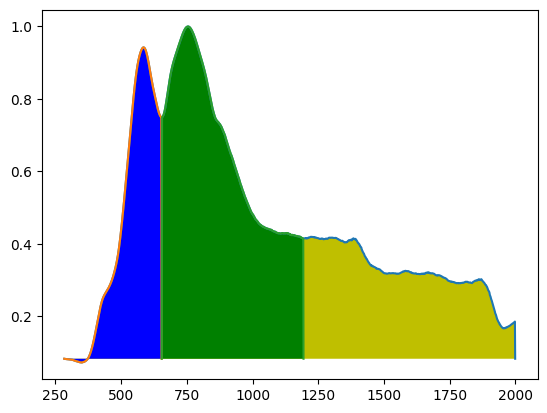

gamma: 0.38784730187078625
plot maxima


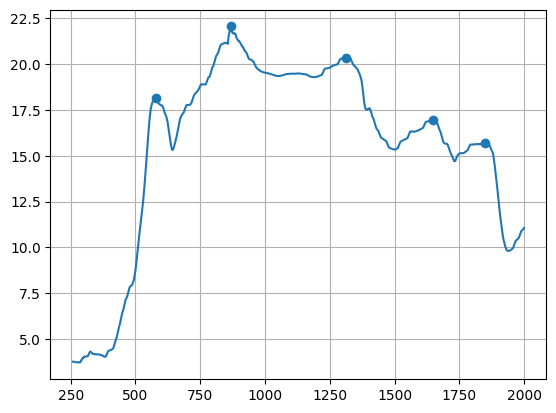

plot minima


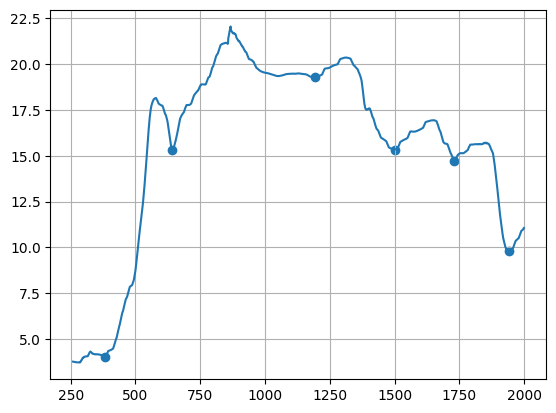

fmi: 383


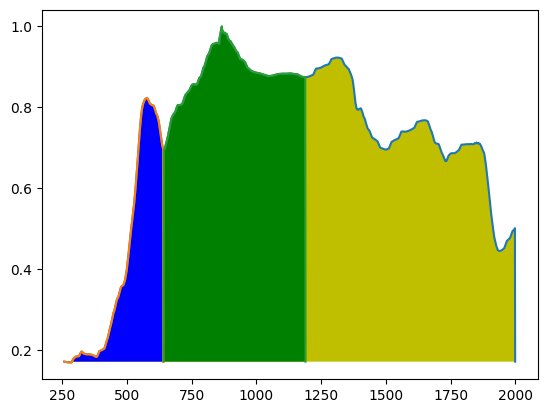

gamma: 0.24028636609085247
plot maxima


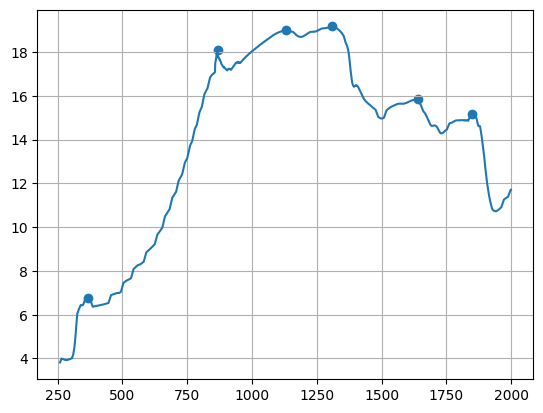

plot minima


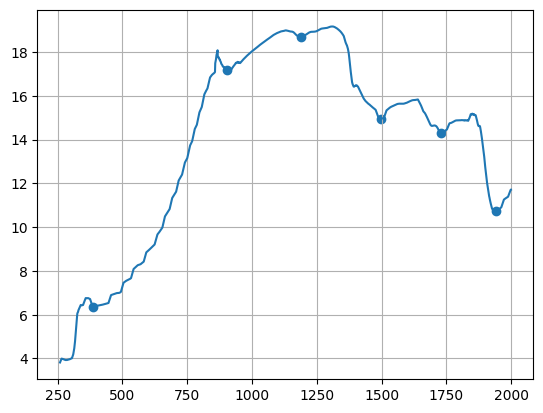

fmi: 127


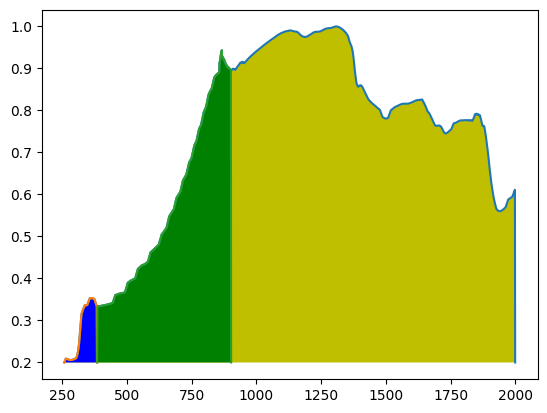

gamma: 0.0
plot maxima


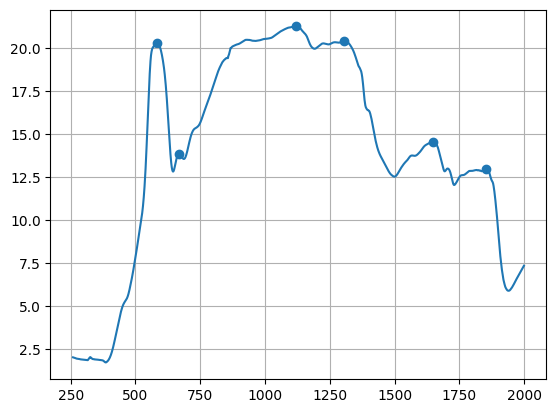

plot minima


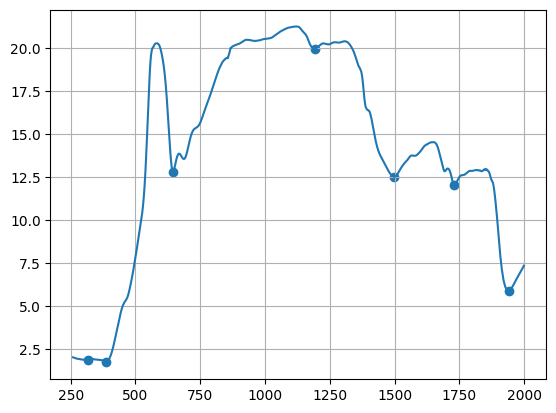

fmi: 386


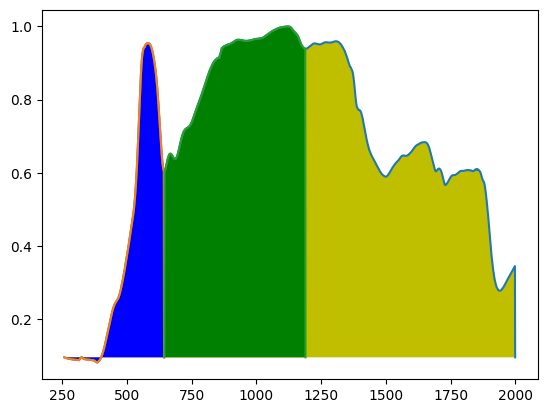

gamma: 0.2496198286067138
plot maxima


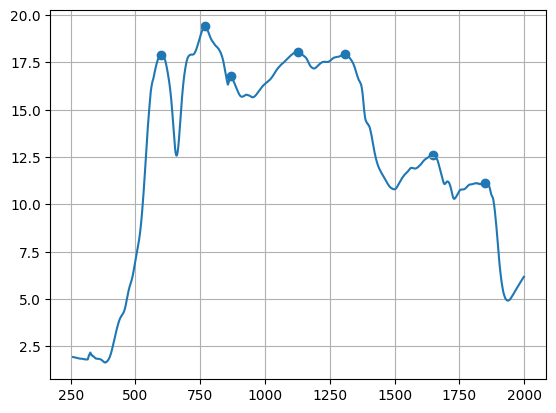

plot minima


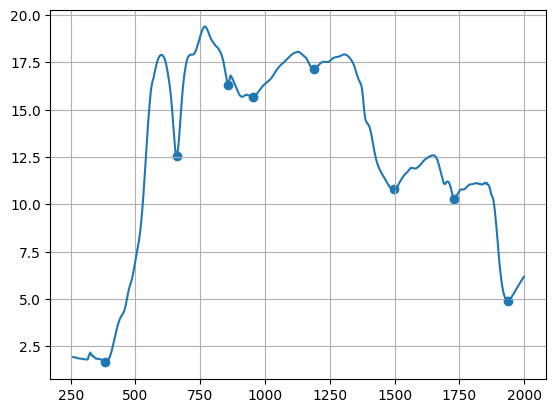

fmi: 400


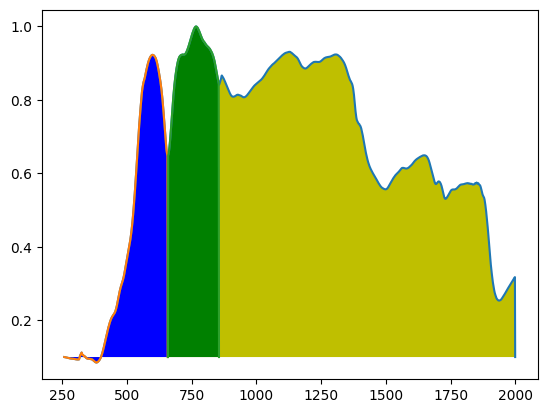

gamma: 0.7302946732001424
plot maxima


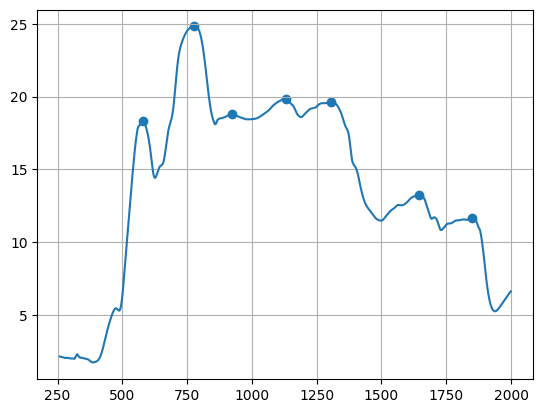

plot minima


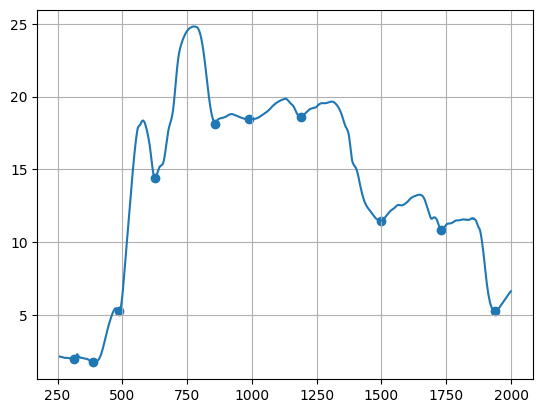

fmi: 367


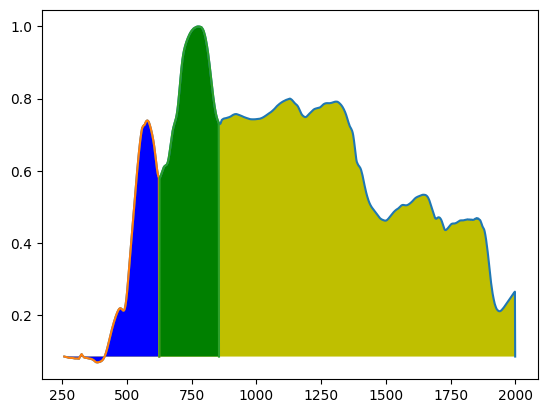

gamma: 0.4448617601244163
plot maxima


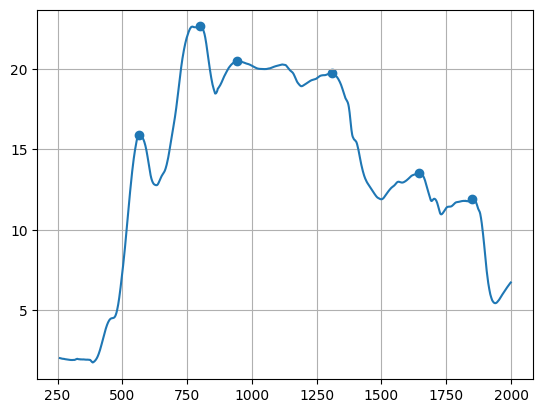

plot minima


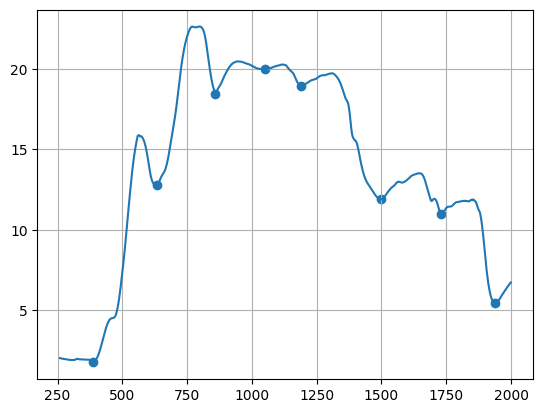

fmi: 373


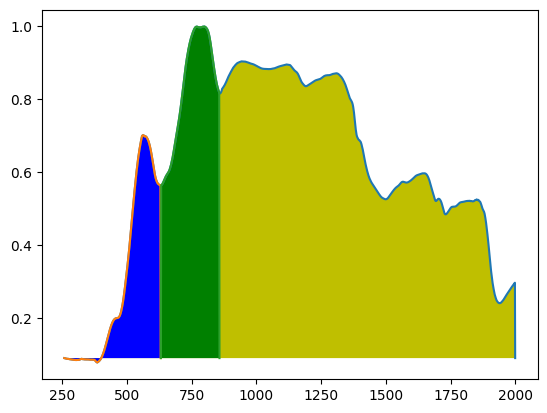

gamma: 0.46988987749958605
plot maxima


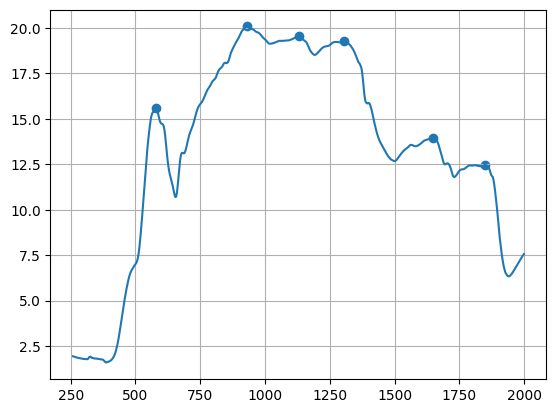

plot minima


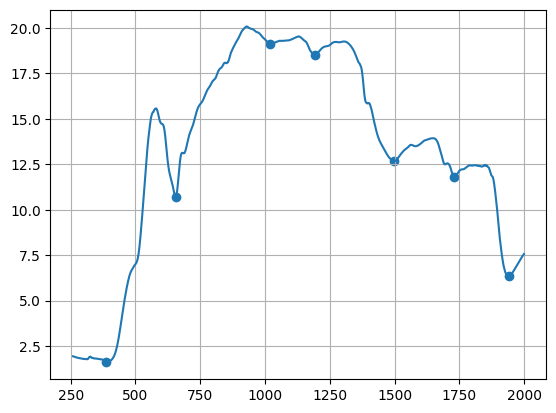

fmi: 396


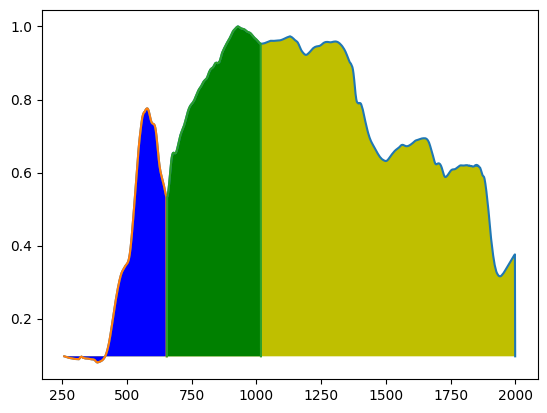

gamma: 0.355927853195631
plot maxima


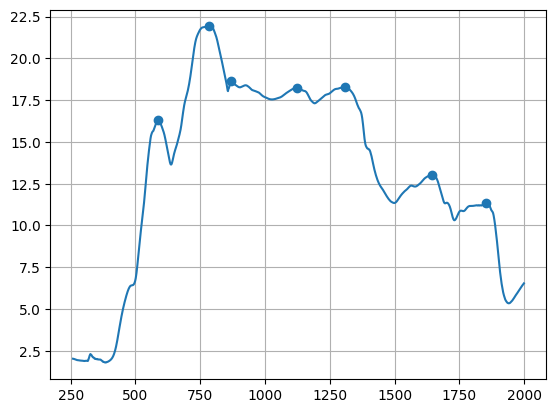

plot minima


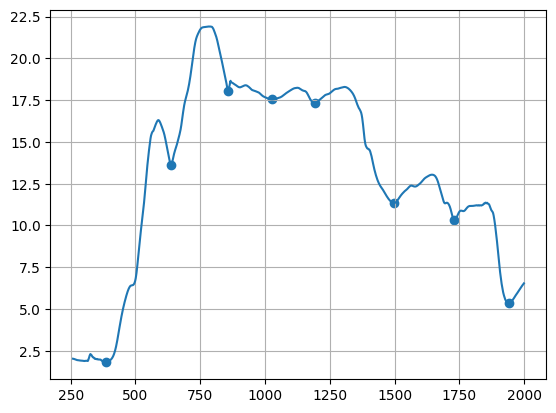

fmi: 378


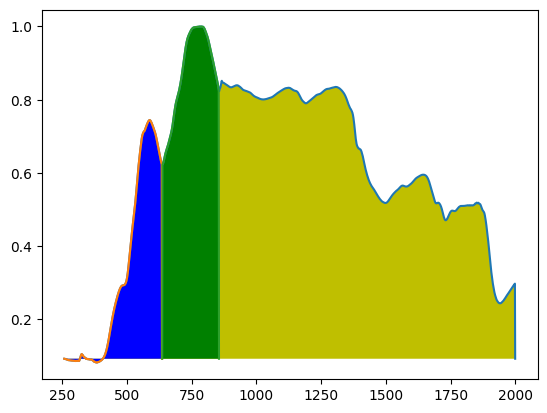

gamma: 0.5080565700847386
plot maxima


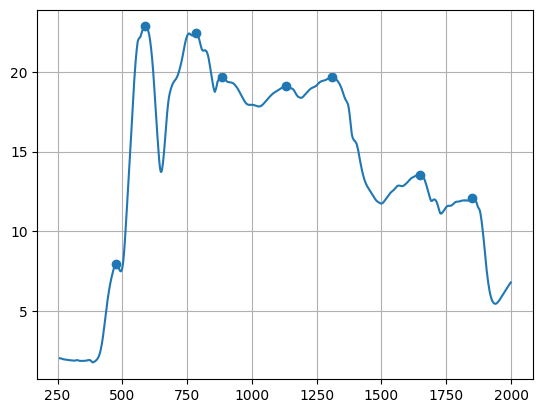

plot minima


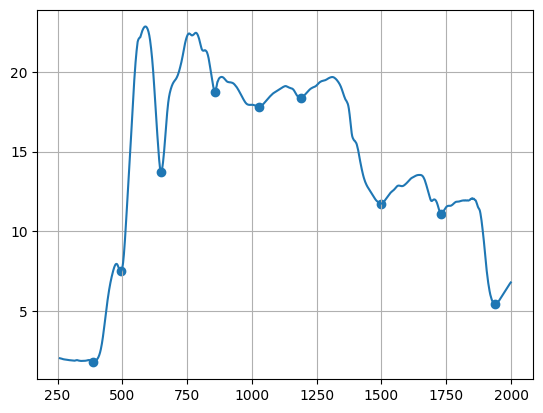

fmi: 235


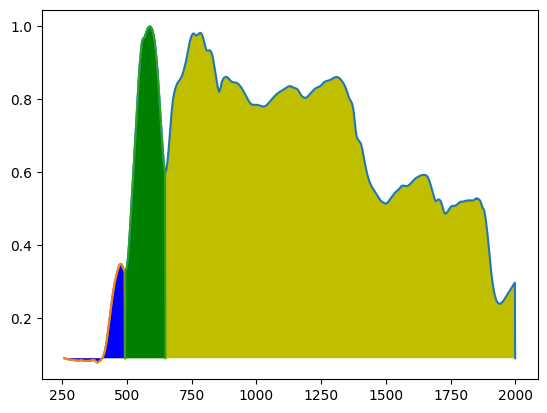

gamma: 0.11747611940424231
plot maxima


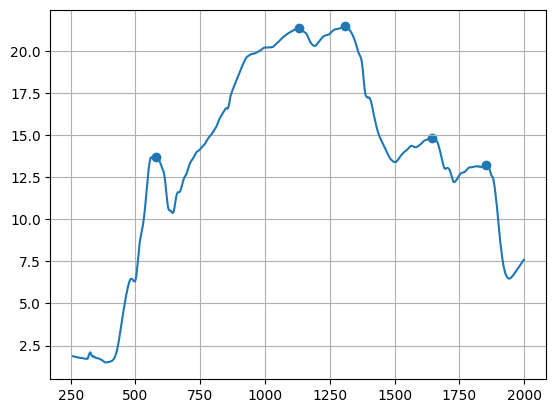

plot minima


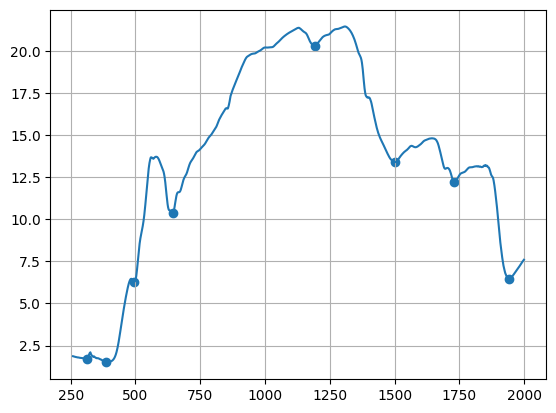

fmi: 385


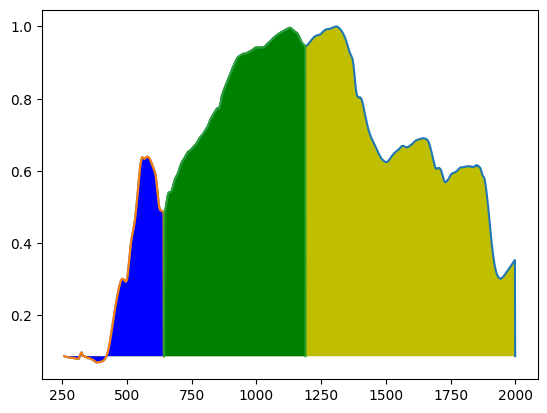

gamma: 0.2001428261557006
plot maxima


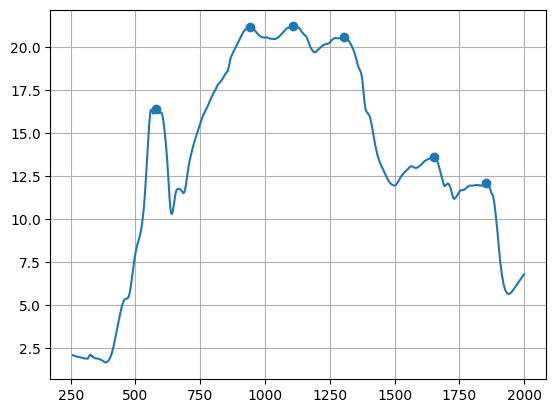

plot minima


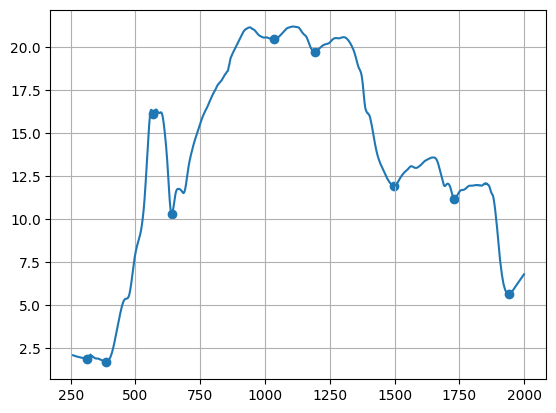

fmi: 381


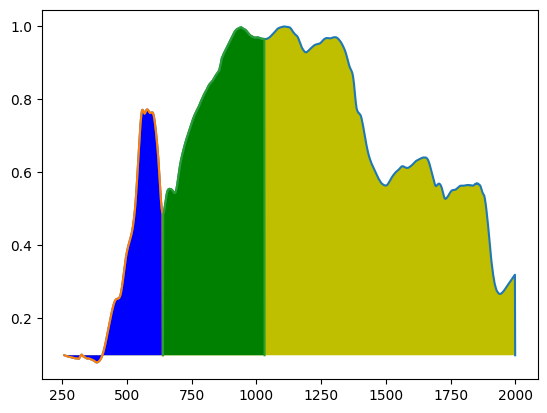

gamma: 0.3152782825363858
plot maxima


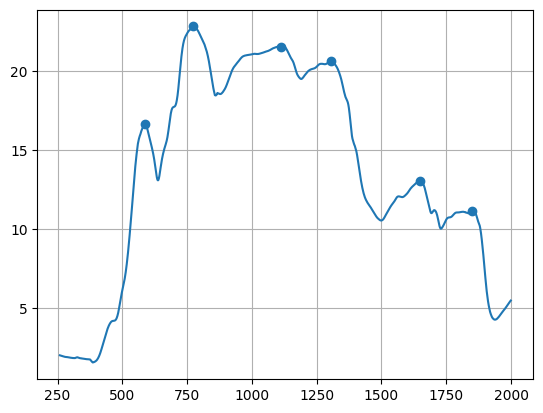

plot minima


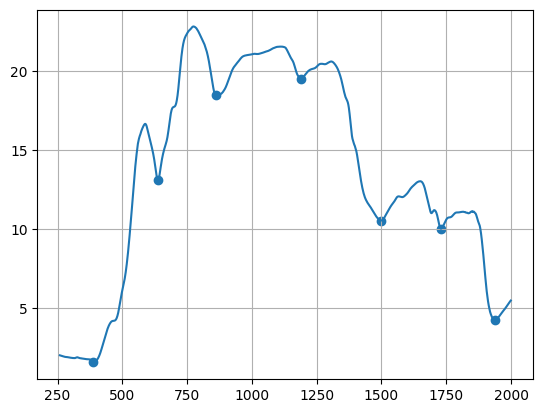

fmi: 378


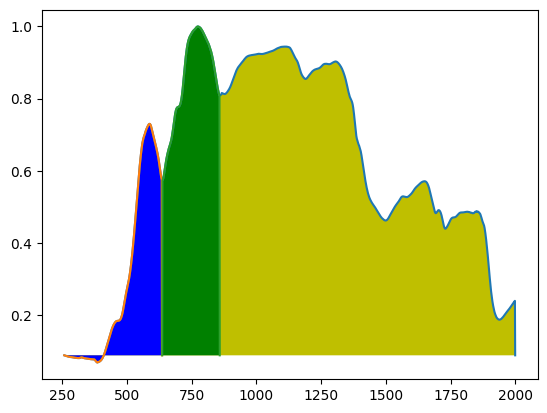

gamma: 0.4672650502625854
plot maxima


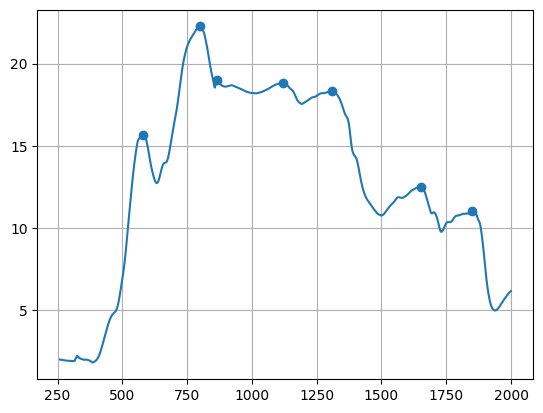

plot minima


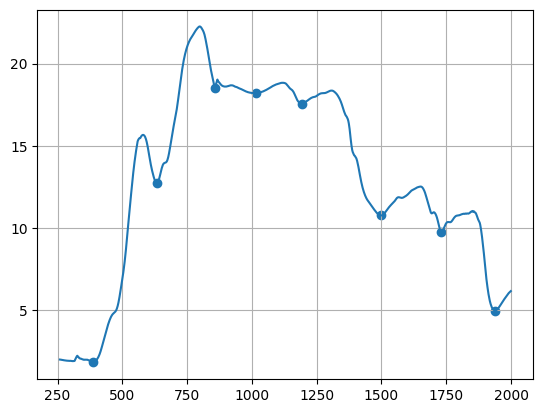

fmi: 374


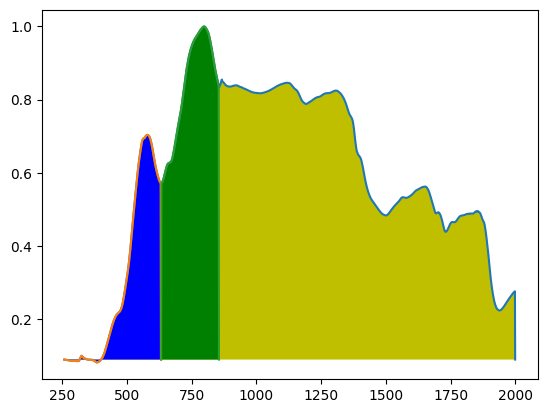

gamma: 0.4797032896746524
plot maxima


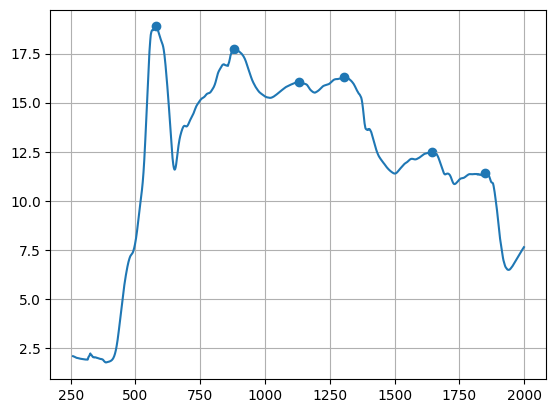

plot minima


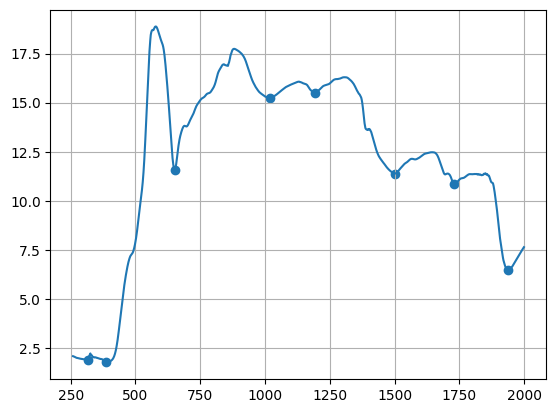

fmi: 392


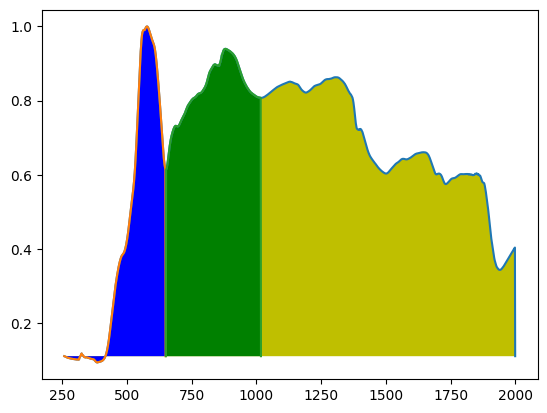

gamma: 0.4488256749117401
plot maxima


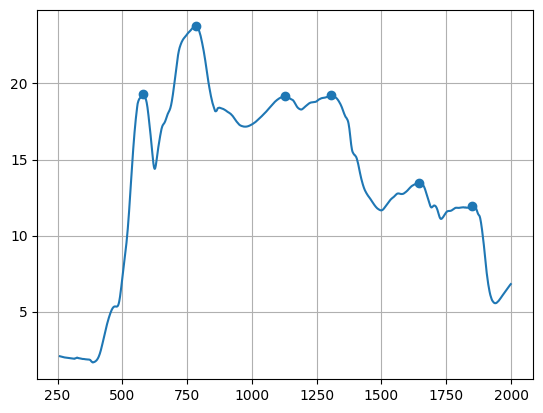

plot minima


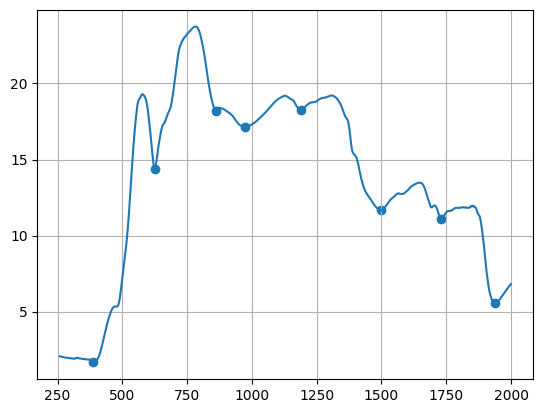

fmi: 366


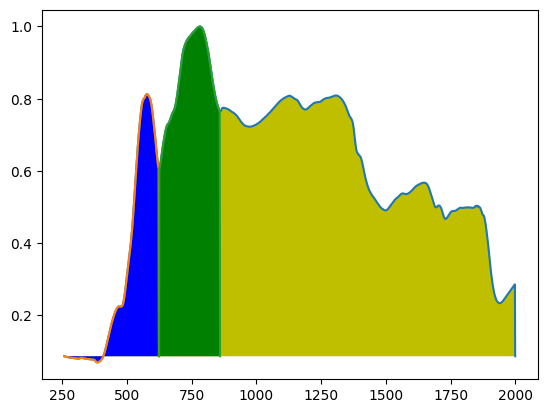

gamma: 0.4552322789845634
plot maxima


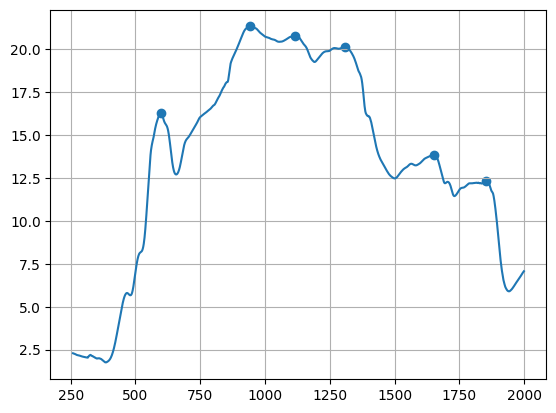

plot minima


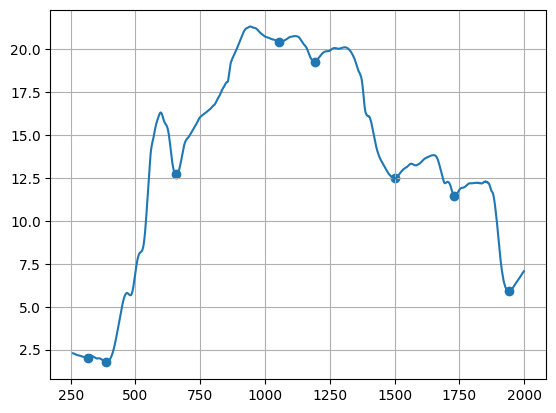

fmi: 398


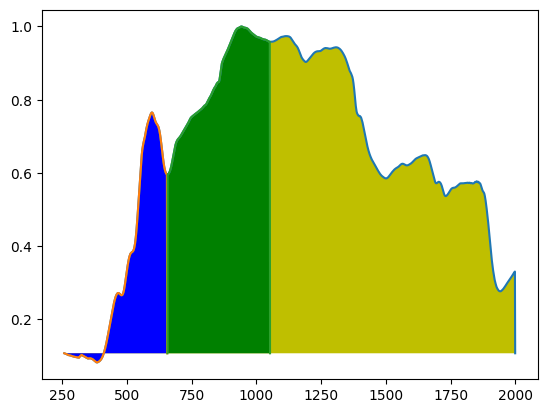

gamma: 0.31958904983023817
plot maxima


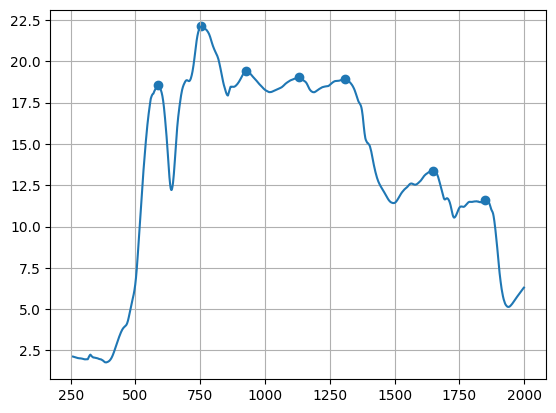

plot minima


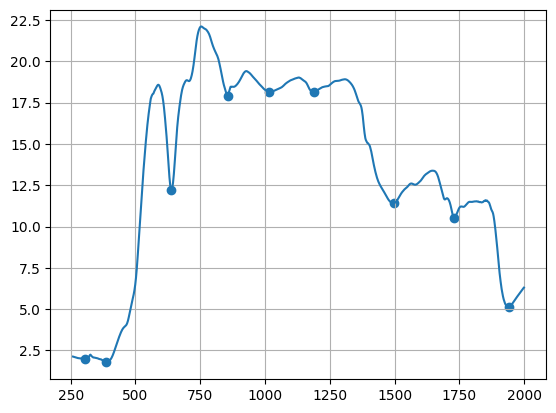

fmi: 380


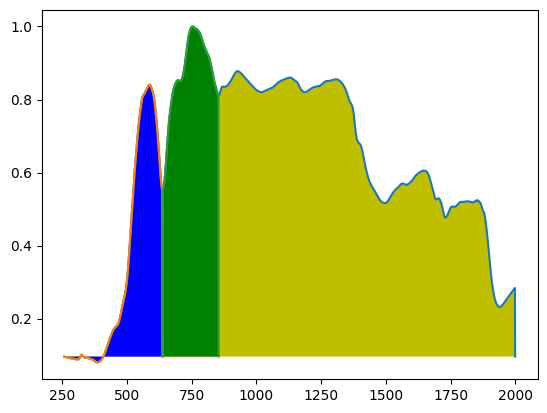

gamma: 0.5569906558406261
plot maxima


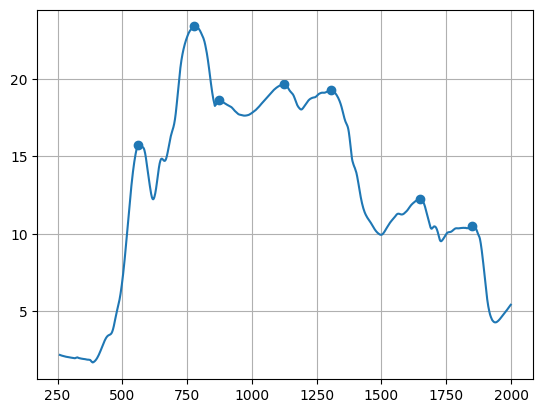

plot minima


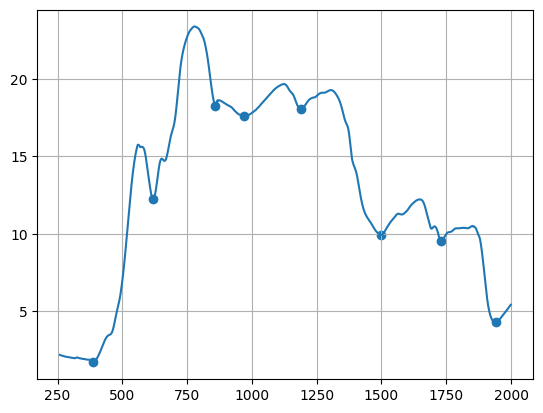

fmi: 360


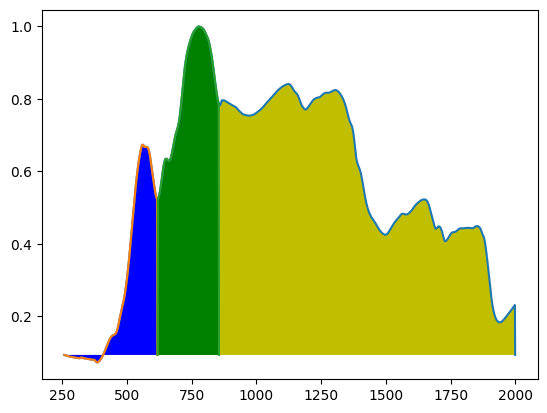

gamma: 0.39360211464897077
plot maxima


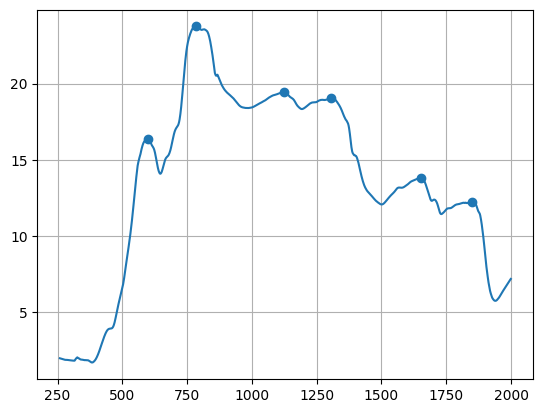

plot minima


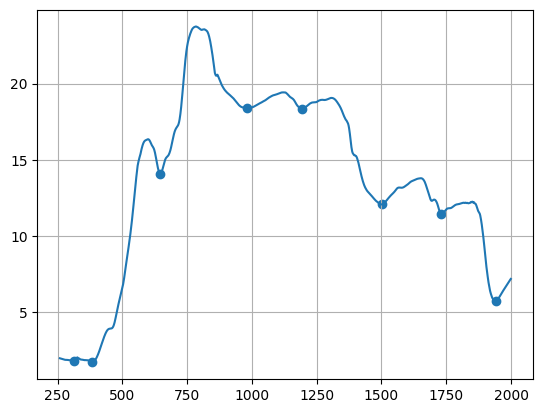

fmi: 388


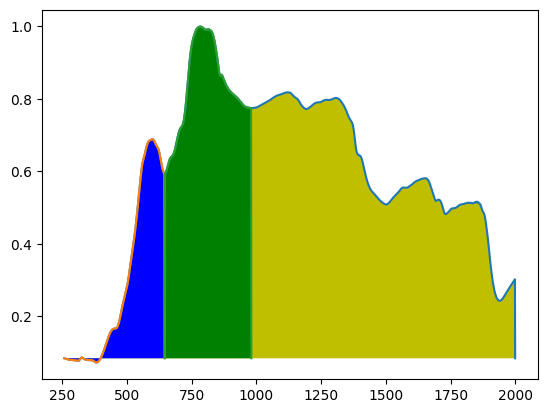

gamma: 0.33270555429036414
plot maxima


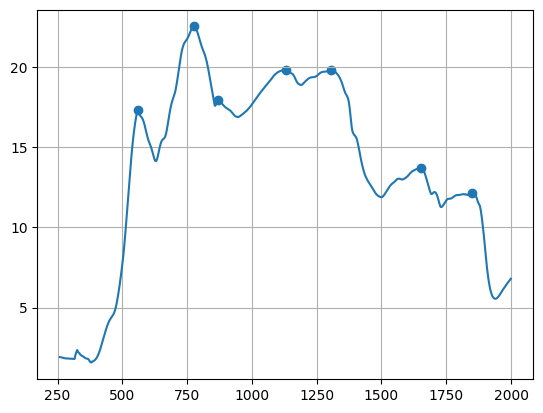

plot minima


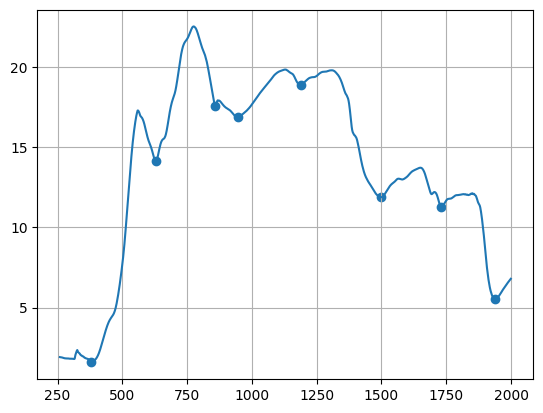

fmi: 370


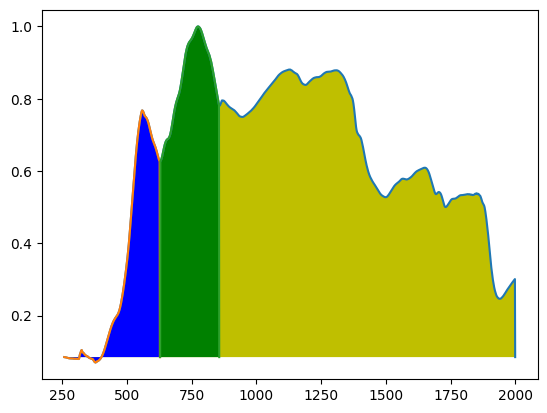

gamma: 0.4845956896773962
plot maxima


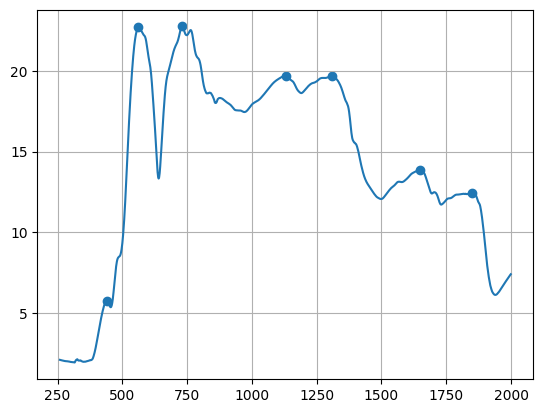

plot minima


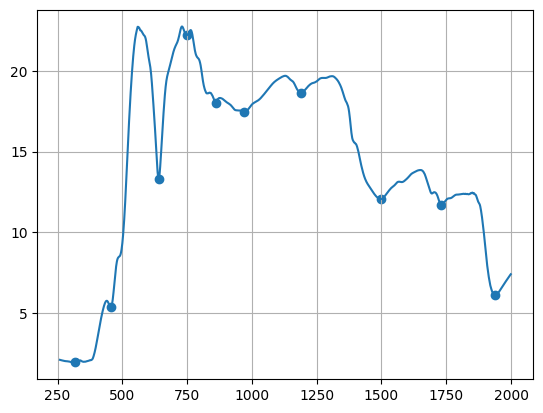

fmi: 196


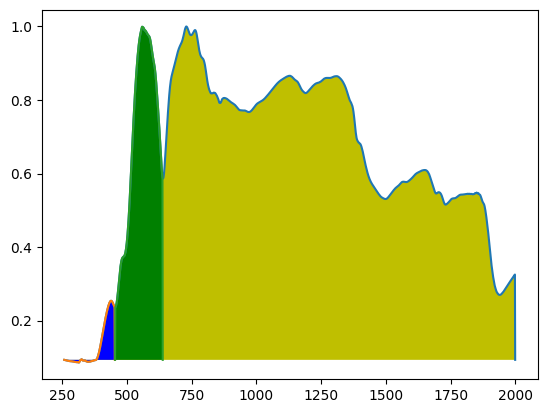

gamma: 0.00752895484509918
plot maxima


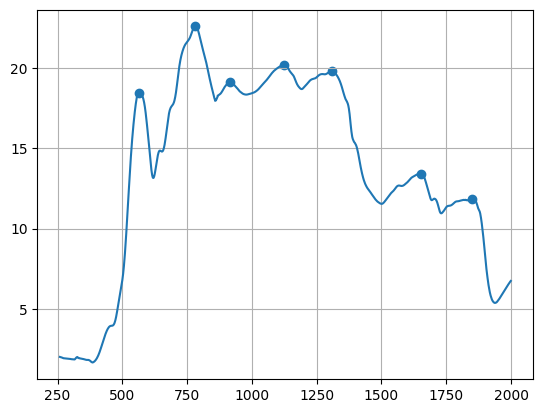

plot minima


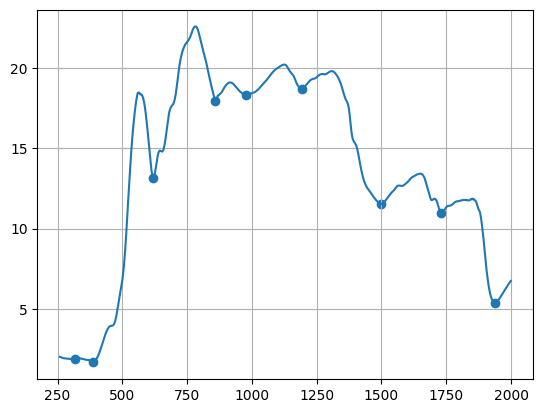

fmi: 360


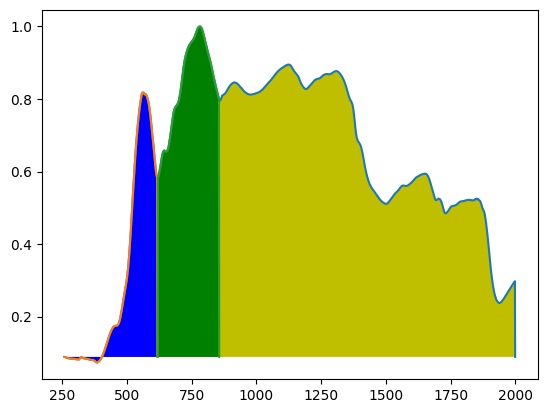

gamma: 0.44210264578997394
plot maxima


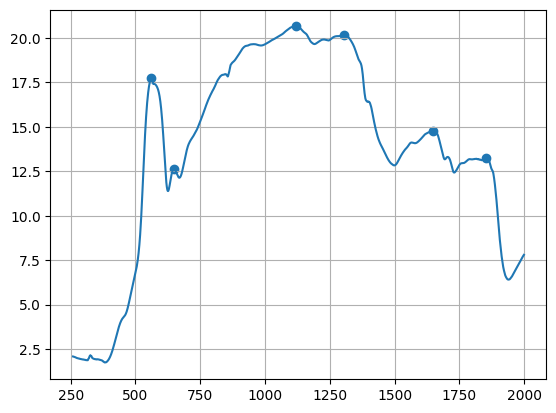

plot minima


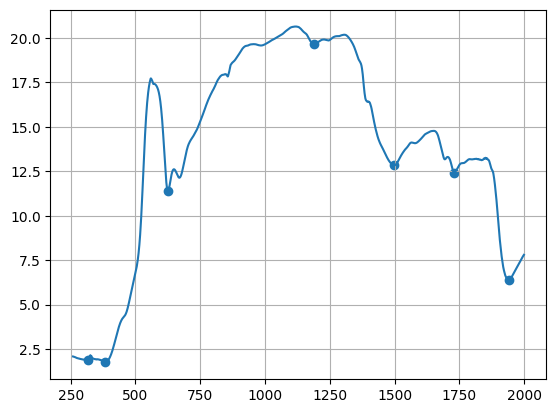

fmi: 366


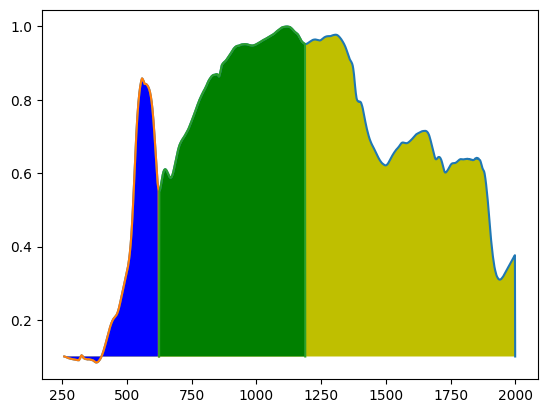

gamma: 0.19974999350845504
plot maxima


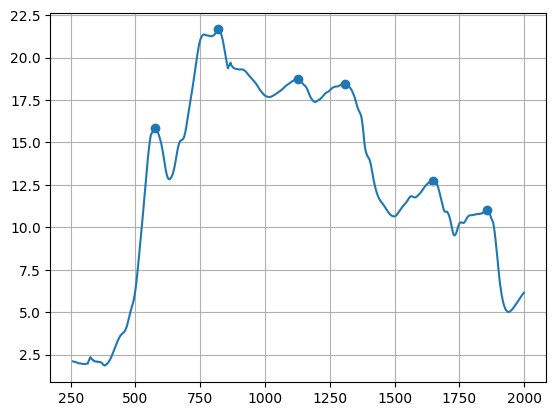

plot minima


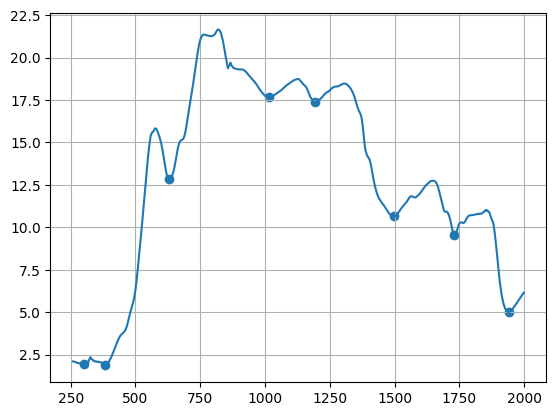

fmi: 371


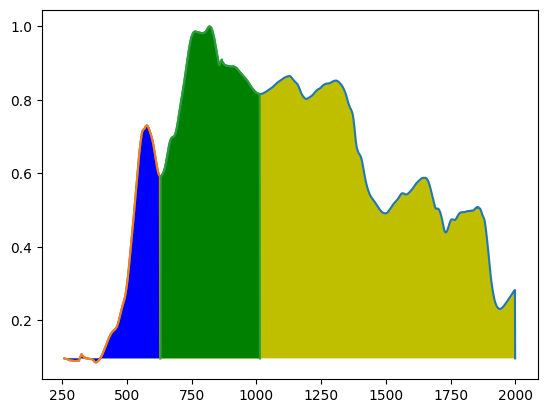

gamma: 0.2674237599147513
plot maxima


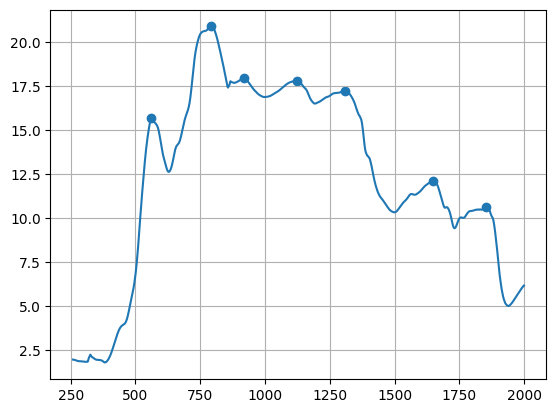

plot minima


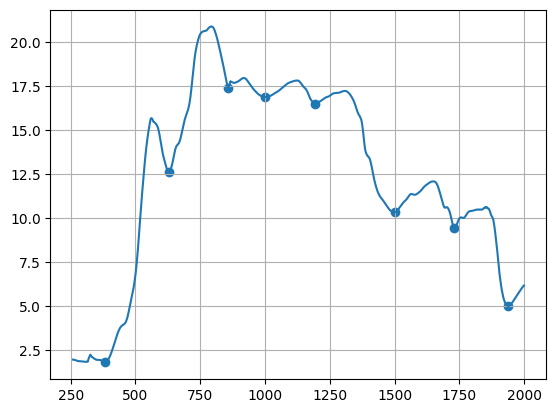

fmi: 369


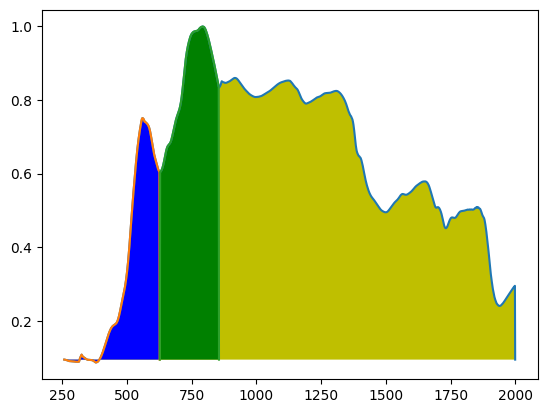

gamma: 0.4721410650045173
type <class 'str'> bp_path


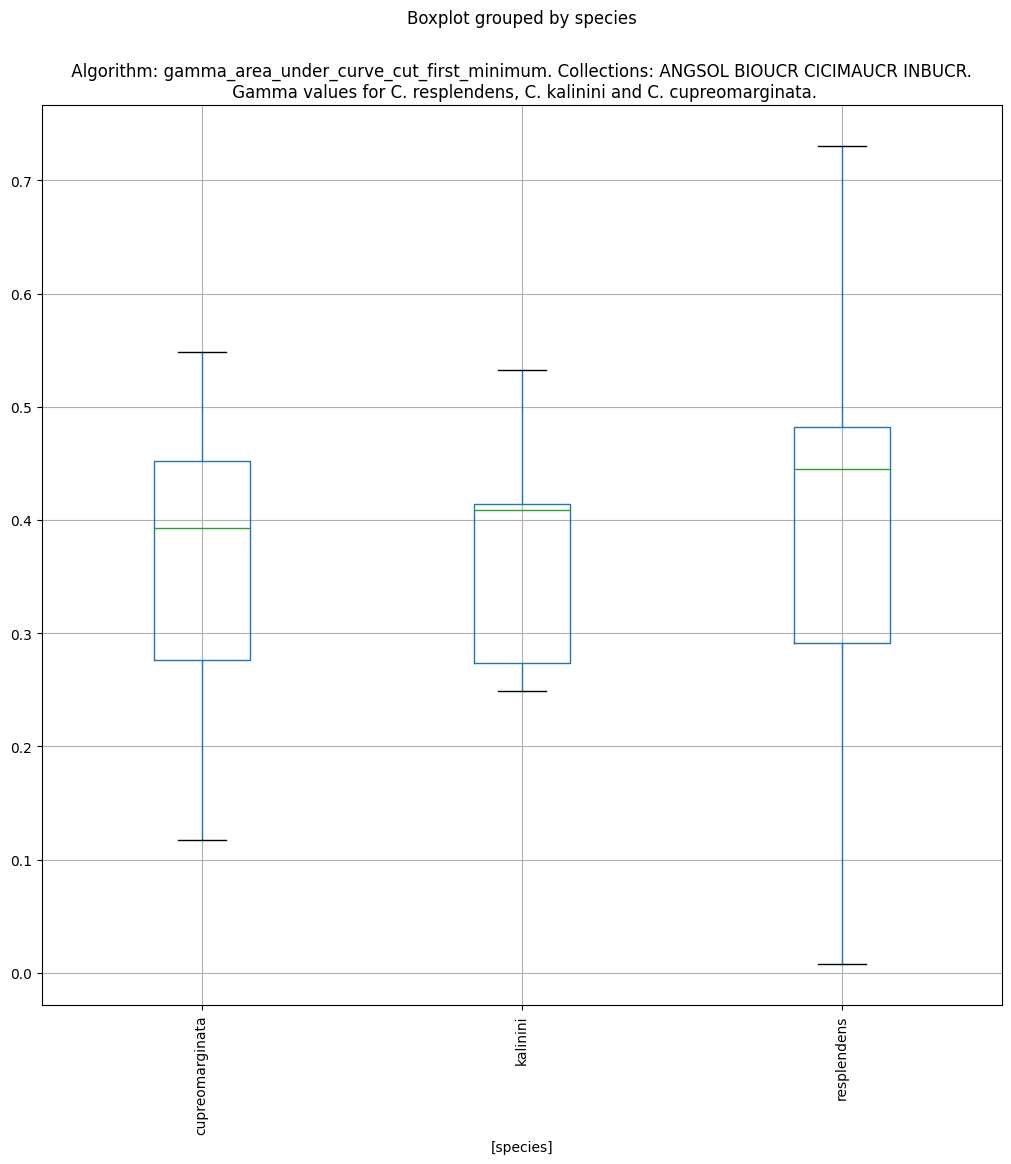

In [166]:
gamma_test =GammaAreaFirstMinCut
bp_path =gamma_testbench(gamma_test, filtered_spectra)
print(f"type {type(bp_path)} bp_path")
gamma_area_first_min_cut_section = gamma_analysis( gamma_test, bp_path  , "sample_text", "sample_text")


In [167]:
# test_spectrum = filtered_spectra[0]
# #get the highest data recorded
# max_value = spectrum.data[spectrum.measuring_mode].max()
# #get maxima and minima
# x = spectrum.data["wavelength"].values
# y = spectrum.data[spectrum.measuring_mode].values

# #get x and y positions of maxima and minima
# max_i, max_xs, max_ys = get_maxima(spectrum)
# min_i, min_xs, min_ys= get_minima(spectrum)
# #
# print(f"type min_i {type(min_i)}, content {min_i}")
# print(f"type max_i {type(max_i)}, content {max_i}")
# print(f"type max_xs {type(max_xs)}, content {max_xs}")
# print(f"type max_ys {type(max_ys)}, content {max_ys}")
# print(f"type min_xs {type(min_xs)}, content {min_xs}")
# #normalize y values
# max_ys = max_ys
# min_ys = min_ys
# #get x locations of first and second maxima and the minimum in between
# first_max_x = max_xs[0]
# second_max_x = max_xs[1]

# min_in_between_i = 0
# min_in_between_x =0
# min_in_between_y =0
# #get the location of the minimum in between
# for index in min_i:
#     print("index")
#     if first_max_x <= x[index] <= second_max_x:
#         min_in_between_i = index
#         min_in_between_x = x[index]
#         min_in_between_y = y[index]
#         break

# print(f"min in bet: {min_in_between_i} {min_in_between_x} {min_in_between_y} ")
# #second minimum
# #get the location of the second minimum
# min_after_second_max_i = 0
# min_after_second_max_x = 0
# min_after_second_max_y = 0
# for index in min_i:
#     print(f" second_max_x  <= x[index] { second_max_x  <= x[index]}")
#     if second_max_x  <= x[index]:
#         min_after_second_max_i = index
#         min_after_second_max_x = x[index]
#         min_after_second_max_y = y[index]
#         break


# print(f"min after: {min_after_second_max_i} {min_after_second_max_x} {min_after_second_max_y} ")

# x_values = [first_max_x, minimum_in_between_x, second_max_x, min_after_second_max_x]
# y_values = [max_values[0]/max_value, minimum_in_between_y/max_value, max_values[1]/max_value, min_after_second_max_y/max_value]
# #get the normalized spectrum
# df = test_spectrum.get_normalized_spectrum()
# #plot
# x = df["wavelength"].values
# y =df[test_spectrum.measuring_mode].values
# plt.plot(x,y)
# #plt.fill(x, y, "c")
# #split x, y LEFT
# print(f"fmi: {first_minimum_index}")
# x_left = x[:min_in_between_i]
# y_left = y[:min_in_between_i]
# #set last one to zero for picture to be displaye properly
# y_left[-1] = y_left[0]
# plt.plot(x_left,y_left)
# plt.fill(x_left, y_left, "b")

# #split x, y RIGHT
# print(f"fmi: {first_minimum_index}")
# x_right = x[min_in_between_i:min_after_second_max_i]
# y_right = y[min_in_between_i:min_after_second_max_i]
# #set last one to zero for picture to be displaye properly
# y_right[0] = y_right[-1] = y_left[0]
# plt.plot(x_right,y_right)
# plt.fill(x_right, y_right, "g")

# area_uv_visible = get_area_under_curve(spectrum, 400, minimum_in_between_x)
# area_ir = get_area_under_curve(spectrum, minimum_in_between_x, minimum_after_max_x)
# gamma = area_uv_visible/area_ir
# print(f"gamma: {gamma}")


In [170]:
# Create PDF report
def create_report():
    elements = create_title_page()
    #sections, sections_start_pages = create_sections()
    elements += specimen_section
    elements += simple_gamma_section
    elements += gamma_area_under_curve_naive_section
    elements += gamma_area_first_min_cut_section
    elements += similarity_index_section
    #elements += create_table_of_contents()

    ##elements += sections
    elements += create_bibliography()

    # # Update table of contents with page numbers
    # toc_style = getSampleStyleSheet()["Heading1"]
    # #toc_data = [[Paragraph(section, toc_style), str(page_num)] for section, page_num in sections_start_pages.items()]
    # toc_data = ["1"]
    # toc_table = Table(toc_data)
    # toc_table.setStyle(TableStyle([('ALIGN', (0, 0), (-1, -1), 'CENTER')]))
    # elements[-1] = toc_table
    # elements += create_table_of_contents(toc_data)

    doc = SimpleDocTemplate(report_location + f"\\gamma analysis {collection_names}.pdf", pagesize=letter)
    doc.build(elements)

create_report()

###